##Datos extrajudiciales

Optecion de parquet jobs


In [ ]:
import os
from bs4 import BeautifulSoup
import pandas as pd

# Ruta de tu carpeta
carpeta_html = "G:\Jobs"

# Lista para almacenar resultados
data = []

for archivo in os.listdir(carpeta_html):
    if archivo.endswith(".html"):
        job_id = os.path.splitext(archivo)[0]
        ruta_completa = os.path.join(carpeta_html, archivo)

        with open(ruta_completa, "r", encoding="utf-8") as f:
            soup = BeautifulSoup(f, "html.parser")
            texto = soup.get_text(separator=" ", strip=True)
            data.append({"job_id": job_id, "descripcion_texto": texto})

df_descripciones = pd.DataFrame(data)
df_descripciones.to_parquet("descripciones_trabajo.parquet", index=False)

## Informacion de data / Formato inicial
En esta parte incial simplemente revizaremos el tipo de informacion que poseemos y arreglaremos lo necesario.

In [ ]:
import pandas as pd

In [ ]:
df2 = pd.read_parquet('/content/applications.parquet')

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617106 entries, 0 to 617105
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   applicationId      617106 non-null  object
 1   applicationStatus  617106 non-null  object
 2   candidateId        617106 non-null  object
 3   jobId              617106 non-null  object
dtypes: object(4)
memory usage: 18.8+ MB


Revizamos la densidad de nuestros datos, encontrando que hay 8000 personas para el trabajo 60934

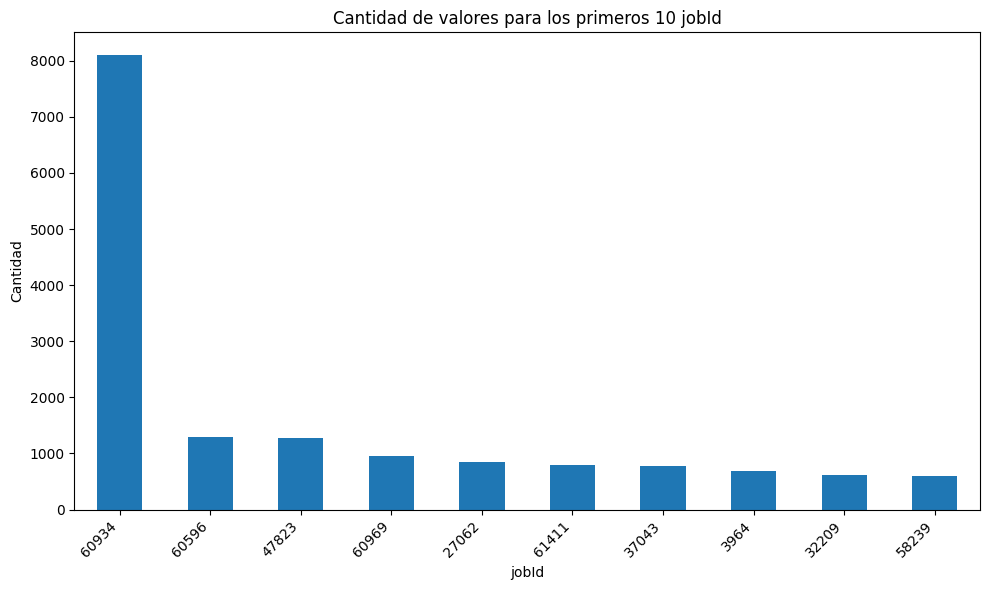

In [ ]:
import matplotlib.pyplot as plt

# Suponiendo que df2['jobId'] contiene los IDs de trabajo
job_counts = df2['jobId'].value_counts().head(10)

plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura si es necesario
job_counts.plot(kind='bar')
plt.title('Cantidad de valores para los primeros 10 jobId')
plt.xlabel('jobId')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')  # Rota las etiquetas del eje x para mejor legibilidad
plt.tight_layout() # Ajusta el diseño para evitar que las etiquetas se superpongan
plt.show()


Densidad de candidatos en el dataframe (porque alguien esta 404 veces? o.O)

In [ ]:
df2['candidateId'].value_counts()

,count
candidateId,
16046,404
54958,393
105731,306
30120,304
155470,266
...,...
282021,1
268010,1
3922,1


In [ ]:
df2[df2['candidateId'] == "16046"]

,applicationId,applicationStatus,candidateId,jobId
18947,213917,Aplicación del Candidato,16046,32289
19174,467327,Aplicación del Candidato,16046,51813
20031,289444,Aplicación del Candidato,16046,41929
20570,419784,Aplicación del Candidato,16046,52842
20849,398470,Aplicación del Candidato,16046,52193
...,...,...,...,...
595470,425224,No cubre el perfil por el área,16046,52829
596806,435546,No cubre el perfil por el área,16046,53289
599549,127141,No cubre el perfil por el área,16046,22802
599636,415041,No cubre el perfil por el área,16046,52718


Candidatos totales

In [ ]:
df2['candidateId'].nunique()

172341

Calculamos cuantos candidatos vamos a necesitar para entrenar el modelo

In [ ]:
import math

def tamano_muestra_finita(poblacion, confianza, margen_error):
  """
  Calcula el tamaño de muestra necesario para una población finita.

  Args:
    poblacion: Tamaño de la población.
    confianza: Nivel de confianza (como decimal, p.ej., 0.99 para 99%).
    margen_error: Margen de error deseado (como decimal).

  Returns:
    El tamaño de muestra necesario.
  """
  z = abs(0) # Valor Z para el nivel de confianza dado
  if confianza == 0.99:
    z = 2.576
  elif confianza == 0.95:
    z = 1.96
  elif confianza == 0.90:
    z = 1.645

  n = (poblacion * (z**2) * 0.25) / ((poblacion - 1) * (margen_error**2) + (z**2) * 0.25)
  return math.ceil(n)  # Redondeamos hacia arriba al entero más cercano


poblacion_total = 172341
nivel_confianza = 0.99  # 99%
margen_error = 0.02  # 2%

tamano_muestra = tamano_muestra_finita(poblacion_total, nivel_confianza, margen_error)

print(f"El tamaño de muestra necesario es: {tamano_muestra}")


El tamaño de muestra necesario es: 2453


Entonces necesitamos crear una muestra de 4000 candidatos para representar nuestra poblacion finita de 172341!

--------------------------------------------------------------------------------

## Classification / Etiquetado

En esta parte clasificaremos los tipos de procesos para darles valor dependiendo el progreso que el candidato logro y no solo tener un valor booleano 1 Contratado - 0 No contratado.

* Eliminados por xd
  * Auto Disqualified
  * Default
  * Deleted On Demand By Candidate
  * Withdrawn By Candidate
  * Requisition Closed
  * candidatonointeresado
  * Bolsa de trabajo/Cierre de vacante
  * Aplicación del Candidato

*   Descartado/inactivo inmediato - 0
  * No cubre el perfil por RH
  * No cubre el perfil por el área
  * Descartada Ubicacion
  * Rechazado por referencias
  * Rechazado por EMI

*  Aplicación / contacto inicial - 1
  * Llamada Inicial
  * Evaluaciones
  * Entrevista RH
  * Entrevista con Jefe de Área
  * Referencia/ Estudio Socioeconómico
  * Validación Sociolaboral
  * Examen Médico

* Etapas avanzadas / finalistas - 2
  * Envio de oferta
  * Precontratacion
  * Aprobación de Contratación
  * Hired On Other Requisition
  * Contratación
  * ONB Incorporación del Personal  

In [ ]:
df2.head()

,applicationId,applicationStatus,candidateId,jobId
0,820357,Entrevista RH,141314,63093
1,709889,Entrevista con Jefe de Área,300033,59926
2,805620,Auto Disqualified,266004,62527
3,786877,candidatonointeresado,199988,62126
4,91917,Deleted On Demand By Candidate,46147,16474


In [ ]:
Drop = {
    'Auto Disqualified',
    'Default',
    'Deleted On Demand By Candidate',
    'Withdrawn By Candidate',
    'Requisition Closed',
    'candidatonointeresado',
    'Bolsa de trabajo/Cierre de vacante',
    'Aplicación del Candidato',
    'Candidato no interesado',
    'Rechazado por EMI',
    'Rechazado por referencias',
    'Descartada Ubicacion',
    'DescartadoJornadaHib',
    'Hired On Other Requisition',
    'Declined DPCS',
}
application_progress_mapping = {                 #Creamos un mapa con los valores que necesitamos remplazar
    'No cubre el perfil por RH': 0,
    'No cubre el perfil por el área': 0,
    'Llamada Inicial': 1,
    'Evaluaciones': 1,
    'Entrevista RH': 1,
    'Entrevista con Jefe de Área': 1,
    'Referencia/ Estudio Socioeconómico': 1,
    'Validación Sociolaboral': 1,
    'Examen Médico': 1,
    'Envio de oferta': 2,
    'Precontratacion': 2,
    'Aprobación de Contratación': 2,
    'Contratación': 2,
    'ONB Incorporación del Personal': 2
}
#Matamos informacion ruidosa
df2 = df2[~df2['applicationStatus'].isin(Drop)]
#Renombramos por un nuevo nombre mas acorde
df2 = df2.rename(columns={'applicationStatus': 'applicationProgress'})
#Remplazamos los datos con los del diccionario
df2['applicationProgress'] = df2['applicationProgress'].map(application_progress_mapping).fillna(df2['applicationProgress']) #Llenamos los nulos

In [ ]:
df2.head()

,applicationId,applicationProgress,candidateId,jobId
0,820357,1,141314,63093
1,709889,1,300033,59926
5,393938,2,181754,52071
6,173533,1,88018,27662
7,229864,2,95156,32646


In [ ]:
df2['applicationProgress'] = df2['applicationProgress'].astype(int)

## Creacion del dataset

In [ ]:
"""# Group by 'candidateId' and keep the row with the highest 'applicationProgress' for each candidate
df2 = df2.loc[df2.groupby('candidateId')['applicationProgress'].idxmax()]""" #ESTA GRACIOSADA MATA TODA RELACION PARA QUE EL MODELO PUEDA APRENDER

In [ ]:
df2.shape

(288046, 4)

Verificamos que efectivamente no tengamos diferentes niveles para un mismo proceso

In [ ]:
"""duplicate_candidates = df_final_sample[df_final_sample.duplicated(subset=['applicationId'], keep=False)]
duplicate_candidates"""

"duplicate_candidates = df_final_sample[df_final_sample.duplicated(subset=['applicationId'], keep=False)]\nduplicate_candidates"

Una vez verficado podemos desasernos de applicationId

In [ ]:
"""df_final_sample = df_final_sample.drop(columns=['applicationId'], errors='ignore')
df_final_sample.head()"""

,applicationProgress,candidateId,jobId
0,0.0,7806,56105
1,0.0,148970,38242
2,0.0,2205,18404
3,0.0,58547,20927
4,0.0,297979,58848


*Ahora* tenemos la base para la creacion de nuestro dataset, solo necesitamos añadirle los datos extra

In [ ]:
df_final_sample = df2.copy()

In [ ]:
education = pd.read_parquet('/content/education.parquet')
certificates = pd.read_parquet('/content/certificates.parquet')
work_experience = pd.read_parquet('/content/work_experience.parquet')

In [ ]:
education.head()

,candidateId,major,school,endDate
0,363930,Escolaridad,Juan nepomuceno sanroman,None
1,363153,Bachilerato,CER LINCOLN,None
2,363272,Primaria,Primaria,None
3,365793,Licenciatura,UDG,None
4,365471,Licenciatura,UVM SAN RAFAEL,None


In [ ]:
df_major_grouped = education.groupby("candidateId")["major"].apply(
    lambda majors: ", ".join(set(m for m in majors if pd.notnull(m)))
).reset_index()

In [ ]:
df_major_grouped["major"][3]

'Administracion , Ingenieria en Desarrollo e Innovacion Empresarial, Desarrollo de negocios area Mercadotecnia'

In [ ]:
df_final_sample = df_final_sample.merge(df_major_grouped[["candidateId", "major"]], on="candidateId", how="left")
df_final_sample

,applicationId,applicationProgress,candidateId,jobId,major
0,820357,1,141314,63093,Licenciatura en Químico Farmacobilogía
1,709889,1,300033,59926,MVZ
2,393938,2,181754,52071,Ingeniería Civil
3,173533,1,88018,27662,"Odontología , Odontológicas"
4,229864,2,95156,32646,"Ingeniería en Mecatrónica, Técnico Superior Un..."
...,...,...,...,...,...
288041,113755,0,23990,21703,quimico farmaceutico biotecnologo
288042,249200,0,104991,34043,NEGOCIOS INTERNACIONALES
288043,819306,0,306441,60384,Licenciatura
288044,508477,0,226197,55876,LIC ADMIN DE EMPRESAS


Ahora con certificados

In [ ]:
df_cert_grouped = certificates.groupby("candidateId")["description"].apply(
    lambda cert: ", ".join(set(m for m in cert if pd.notnull(m)))
).reset_index()

In [ ]:
df_cert_grouped["description"][0]

'HERRAMIENTAS COMPUTACIONALES, CURSO TALLER OPERACIONES CATASTRALES, CURSO LLENADO DE FORMATOS HACENDARIAS'

In [ ]:
df_final_sample = df_final_sample.merge(df_cert_grouped[["candidateId", "description"]], on="candidateId", how="left")
df_final_sample = df_final_sample.rename(columns={'description': 'certificates'})
df_final_sample

,applicationId,applicationProgress,candidateId,jobId,major,certificates
0,820357,1,141314,63093,Licenciatura en Químico Farmacobilogía,NaN
1,709889,1,300033,59926,MVZ,"Dirección Estratégica de Ventas, Programa en A..."
2,393938,2,181754,52071,Ingeniería Civil,NaN
3,173533,1,88018,27662,"Odontología , Odontológicas",NaN
4,229864,2,95156,32646,"Ingeniería en Mecatrónica, Técnico Superior Un...","Core Tools, Robots Colaborativos E-Series, PDC..."
...,...,...,...,...,...,...
288041,113755,0,23990,21703,quimico farmaceutico biotecnologo,"Dispensación de medicamentos, Farmacovigilanci..."
288042,249200,0,104991,34043,NEGOCIOS INTERNACIONALES,DIPLOMADO LOGISTICA Y ADMINISTRACION EN LA CAD...
288043,819306,0,306441,60384,Licenciatura,NaN
288044,508477,0,226197,55876,LIC ADMIN DE EMPRESAS,PROFESSIONAL SKILLS FOR INTERNATIONAL BUSINESS...


Ahora experiencia laboral

In [ ]:
work_experience['startDate']

,startDate
0,None
1,None
2,None
3,None
4,None
...,...
286370,/Date(925513200000)/
286371,/Date(986083200000)/
286372,/Date(988675200000)/
286373,/Date(857174400000)/


In [ ]:
def combine_activity_logro(row):
    actividad = row['actividad']
    logro = row['logro']

    if pd.notnull(actividad) and pd.notnull(logro):
        return f"{actividad} : {logro}"
    elif pd.notnull(actividad):
        return actividad
    elif pd.notnull(logro):
        return logro
    else:
        return ""

work_experience["exp_text"] = work_experience.apply(combine_activity_logro, axis=1)


In [ ]:
df_exp_grouped = work_experience.groupby("candidateId")["exp_text"].apply(
    lambda texts: ". ".join(filter(None, texts))
).reset_index()

In [ ]:
df_exp_grouped["exp_text"][104]

'Gerente de Cadena de Suministro : Incremento en la eficiencia de la cadena de suministro, disminución de los inventarios, incremento a la rotación de inventario, incremento en la confiabilidad de inventario . Gerente de Logística y Distribución : Incremento en eficiencia en la Cadena de suministro global, incremento en la confiabilidad de inventarios, disminución ncremento en nivel de servicio '

In [ ]:
df_final_sample = df_final_sample.merge(df_exp_grouped[["candidateId", "exp_text"]], on="candidateId", how="left")
df_final_sample

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text
0,820357,1,141314,63093,Licenciatura en Químico Farmacobilogía,NaN,Analista. Analista quimica de instrumentacion
1,709889,1,300033,59926,MVZ,"Dirección Estratégica de Ventas, Programa en A...",Gerente Comercial DX
2,393938,2,181754,52071,Ingeniería Civil,NaN,Ingeniero de Proyectos Jr
3,173533,1,88018,27662,"Odontología , Odontológicas",NaN,Ventas
4,229864,2,95156,32646,"Ingeniería en Mecatrónica, Técnico Superior Un...","Core Tools, Robots Colaborativos E-Series, PDC...",Ingeniero de Proyectos y Cotizaciones. Ensambl...
...,...,...,...,...,...,...,...
288041,113755,0,23990,21703,quimico farmaceutico biotecnologo,"Dispensación de medicamentos, Farmacovigilanci...",Becario Documentacion. Analista de Operaciones...
288042,249200,0,104991,34043,NEGOCIOS INTERNACIONALES,DIPLOMADO LOGISTICA Y ADMINISTRACION EN LA CAD...,AUX. COMPRAS. ENCARGADA COMPRAS . ENCARGADA CO...
288043,819306,0,306441,60384,Licenciatura,NaN,NaN
288044,508477,0,226197,55876,LIC ADMIN DE EMPRESAS,PROFESSIONAL SKILLS FOR INTERNATIONAL BUSINESS...,EJECUTIVO CUENTA CLAVE. trader


Años de xp

In [ ]:
from datetime import datetime

import re
def parse_dotnet_date(date_str):
    try:
        # Convierte todo a str (maneja NaN, None, etc.)
        s = str(date_str)
        # Busca el número dentro del formato /Date(1234567890000)/
        match = re.search(r"\d{10,}", s)
        if match:
            timestamp = int(match.group()) / 1000  # pasa de ms a segundos
            return pd.to_datetime(timestamp, unit="s")
    except:
        pass
    return pd.NaT

# Convertimos las fechas
work_experience["startDate"] = work_experience["startDate"].apply(parse_dotnet_date)
work_experience["endDate"] = work_experience["endDate"].apply(parse_dotnet_date)

In [ ]:
# Asumimos 1 año de experiencia si falta endDate
def calculate_exp(row):
    if pd.notnull(row["startDate"]):
        if pd.notnull(row["endDate"]):
            delta = row["endDate"] - row["startDate"]
            return max(delta.days / 365, 0)
        else:
            return 1  # Asumimos 1 año si falta endDate
    return 0  # Si no hay startDate

# Aplicamos la lógica fila por fila
work_experience["years_exp"] = work_experience.apply(calculate_exp, axis=1)

# Agrupamos por candidateId y sumamos
exp_total = (
    work_experience.groupby("candidateId")["years_exp"]
    .sum()
    .round(2)
    .reset_index()
)
exp_total.columns = ["candidateId", "total_years_exp"]


In [ ]:
exp_total['total_years_exp'] = exp_total['total_years_exp'].round()

In [ ]:
exp_total.head()

,candidateId,total_years_exp
0,100000,1.0
1,100002,0.0
2,100004,4.0
3,100006,4.0
4,100007,0.0


In [ ]:
exp_total["total_years_exp"].value_counts(dropna=False)

,count
total_years_exp,
1.0,36066
0.0,24535
2.0,19496
3.0,13705
4.0,10479
...,...
92.0,1
116.0,1
101.0,1


Notamos que tenemos algunos outliers

In [ ]:
exp_total[exp_total["total_years_exp"]==215]

,candidateId,total_years_exp
151364,98850,215.0


añadimos a la db final

In [ ]:
df_final_sample = df_final_sample.merge(exp_total[["candidateId", "total_years_exp"]], on="candidateId", how="left")
df_final_sample = df_final_sample.rename(columns={'total_years_exp': 'XpYears'})
df_final_sample

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears
0,820357,1,141314,63093,Licenciatura en Químico Farmacobilogía,NaN,Analista. Analista quimica de instrumentacion,1.0
1,709889,1,300033,59926,MVZ,"Dirección Estratégica de Ventas, Programa en A...",Gerente Comercial DX,5.0
2,393938,2,181754,52071,Ingeniería Civil,NaN,Ingeniero de Proyectos Jr,4.0
3,173533,1,88018,27662,"Odontología , Odontológicas",NaN,Ventas,0.0
4,229864,2,95156,32646,"Ingeniería en Mecatrónica, Técnico Superior Un...","Core Tools, Robots Colaborativos E-Series, PDC...",Ingeniero de Proyectos y Cotizaciones. Ensambl...,2.0
...,...,...,...,...,...,...,...,...
288041,113755,0,23990,21703,quimico farmaceutico biotecnologo,"Dispensación de medicamentos, Farmacovigilanci...",Becario Documentacion. Analista de Operaciones...,4.0
288042,249200,0,104991,34043,NEGOCIOS INTERNACIONALES,DIPLOMADO LOGISTICA Y ADMINISTRACION EN LA CAD...,AUX. COMPRAS. ENCARGADA COMPRAS . ENCARGADA CO...,3.0
288043,819306,0,306441,60384,Licenciatura,NaN,NaN,NaN
288044,508477,0,226197,55876,LIC ADMIN DE EMPRESAS,PROFESSIONAL SKILLS FOR INTERNATIONAL BUSINESS...,EJECUTIVO CUENTA CLAVE. trader,6.0


añadimos trabajos

In [ ]:
chmabas = pd.read_parquet('/content/descripciones_trabajo.parquet')

In [ ]:
merged_df = pd.merge(df_final_sample, chmabas, left_on='jobId', right_on='job_id', how='inner')
merged_df

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,job_id,descripcion_texto
0,820357,1,141314,63093,Licenciatura en Químico Farmacobilogía,NaN,Analista. Analista quimica de instrumentacion,1.0,63093,Tipo de colaborador Confianza Objetivo del pue...
1,709889,1,300033,59926,MVZ,"Dirección Estratégica de Ventas, Programa en A...",Gerente Comercial DX,5.0,59926,1.- Objetivo del puesto: Desarrollar y gestion...
2,393938,2,181754,52071,Ingeniería Civil,NaN,Ingeniero de Proyectos Jr,4.0,52071,1. Principales responsabilidades del puesto: P...
3,173533,1,88018,27662,"Odontología , Odontológicas",NaN,Ventas,0.0,27662,VISITADOR MEDICO 1. Principales responsabilida...
4,229864,2,95156,32646,"Ingeniería en Mecatrónica, Técnico Superior Un...","Core Tools, Robots Colaborativos E-Series, PDC...",Ingeniero de Proyectos y Cotizaciones. Ensambl...,2.0,32646,Ubicación: TLAJOMULCO DE ZUÑIGA 1.- Principale...
...,...,...,...,...,...,...,...,...,...,...
288032,113755,0,23990,21703,quimico farmaceutico biotecnologo,"Dispensación de medicamentos, Farmacovigilanci...",Becario Documentacion. Analista de Operaciones...,4.0,21703,"Desde hace más de 70 años, proveemos medicamen..."
288033,249200,0,104991,34043,NEGOCIOS INTERNACIONALES,DIPLOMADO LOGISTICA Y ADMINISTRACION EN LA CAD...,AUX. COMPRAS. ENCARGADA COMPRAS . ENCARGADA CO...,3.0,34043,1. Principales responsabilidades del puesto Ge...
288034,819306,0,306441,60384,Licenciatura,NaN,NaN,NaN,60384,OBJETIVO DEL PUESTO: Gestionar proyectos de in...
288035,508477,0,226197,55876,LIC ADMIN DE EMPRESAS,PROFESSIONAL SKILLS FOR INTERNATIONAL BUSINESS...,EJECUTIVO CUENTA CLAVE. trader,6.0,55876,PiSA® Farmacéutica es una empresa 100% mexican...


In [ ]:
merged_df = merged_df.drop(columns=['job_id'], errors='ignore')
merged_df

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,descripcion_texto
0,820357,1,141314,63093,Licenciatura en Químico Farmacobilogía,NaN,Analista. Analista quimica de instrumentacion,1.0,Tipo de colaborador Confianza Objetivo del pue...
1,709889,1,300033,59926,MVZ,"Dirección Estratégica de Ventas, Programa en A...",Gerente Comercial DX,5.0,1.- Objetivo del puesto: Desarrollar y gestion...
2,393938,2,181754,52071,Ingeniería Civil,NaN,Ingeniero de Proyectos Jr,4.0,1. Principales responsabilidades del puesto: P...
3,173533,1,88018,27662,"Odontología , Odontológicas",NaN,Ventas,0.0,VISITADOR MEDICO 1. Principales responsabilida...
4,229864,2,95156,32646,"Ingeniería en Mecatrónica, Técnico Superior Un...","Core Tools, Robots Colaborativos E-Series, PDC...",Ingeniero de Proyectos y Cotizaciones. Ensambl...,2.0,Ubicación: TLAJOMULCO DE ZUÑIGA 1.- Principale...
...,...,...,...,...,...,...,...,...,...
288032,113755,0,23990,21703,quimico farmaceutico biotecnologo,"Dispensación de medicamentos, Farmacovigilanci...",Becario Documentacion. Analista de Operaciones...,4.0,"Desde hace más de 70 años, proveemos medicamen..."
288033,249200,0,104991,34043,NEGOCIOS INTERNACIONALES,DIPLOMADO LOGISTICA Y ADMINISTRACION EN LA CAD...,AUX. COMPRAS. ENCARGADA COMPRAS . ENCARGADA CO...,3.0,1. Principales responsabilidades del puesto Ge...
288034,819306,0,306441,60384,Licenciatura,NaN,NaN,NaN,OBJETIVO DEL PUESTO: Gestionar proyectos de in...
288035,508477,0,226197,55876,LIC ADMIN DE EMPRESAS,PROFESSIONAL SKILLS FOR INTERNATIONAL BUSINESS...,EJECUTIVO CUENTA CLAVE. trader,6.0,PiSA® Farmacéutica es una empresa 100% mexican...


In [ ]:
#df_final_sample = df_final_sample.drop(columns=['XpYears'], errors='ignore')

Guradamos la base de datos que usaremos

In [ ]:
merged_df.shape

(288037, 9)

Notamos que perdimos valores porque no estaban las descripciones de los trabajos

In [ ]:
merged_df.to_parquet('CompleteDB_NEW.parquet', index=False)


---



## Limpieza
En esta parte removemos datos incesarios del dataframe incialmente buscando outliers.

In [ ]:
import pandas as pd

In [ ]:
testing = pd.read_parquet('/content/CompleteDB_NEW.parquet')

llanado por si aca

In [ ]:
testing['XpYears'] = testing['XpYears'].fillna(0)
testing['certificates'] = testing['certificates'].fillna("No cuenta con certificados")
testing['major'] = testing['major'].fillna("No tiene título universitario")
testing['exp_text'] = testing['exp_text'].fillna("Sin experiencia laboral relevante")
testing['certificates'] = testing['certificates'].replace('', "No cuenta con certificados")
testing['major'] = testing['major'].replace('', "No tiene título universitario")
testing['exp_text'] = testing['exp_text'].replace('', "Sin experiencia laboral relevante")

Reduccion de clases

In [ ]:
from sklearn.utils import shuffle

# 1. Eliminar valores nulos
filtered = testing.dropna(subset=["descripcion_texto", "certificates", "major", "exp_text", "XpYears", "applicationProgress"])

# 2. Agrupar por applicationId y quedarnos con el progreso más alto
filtered = filtered.sort_values("applicationProgress", ascending=False)
filtered = filtered.drop_duplicates(subset=["applicationId"], keep="first")

# 3. Asegurar que haya múltiples aplicaciones por jobId y candidateId
jobs_with_repeats = filtered["jobId"].value_counts()
candidates_with_repeats = filtered["candidateId"].value_counts()

valid_jobs = jobs_with_repeats[jobs_with_repeats >= 4].index
valid_candidates = candidates_with_repeats[candidates_with_repeats >= 3].index

filtered = filtered[
    (filtered["jobId"].isin(valid_jobs)) &
    (filtered["candidateId"].isin(valid_candidates))
]

# 4. Eliminar duplicados en (candidateId, jobId) dejando solo el progreso más alto
filtered = filtered.sort_values("applicationProgress", ascending=False)
filtered = filtered.drop_duplicates(subset=["candidateId", "jobId"], keep="first")

# 5. Balancear las clases
print("Distribución antes del balanceo:")
print(filtered["applicationProgress"].value_counts())

samples_per_class = 1500
target_classes = filtered["applicationProgress"].unique()

balanced_subsets = []
for cls in target_classes:
    subset = filtered[filtered["applicationProgress"] == cls]
    balanced_sample = subset.sample(n=min(samples_per_class, len(subset)), random_state=42)
    balanced_subsets.append(balanced_sample)

# 6. Concatenar y barajar
final_df = pd.concat(balanced_subsets)
final_df = shuffle(final_df, random_state=42).reset_index(drop=True)

# 7. Verificar
print("Distribución final:")
print(final_df["applicationProgress"].value_counts())
print("Shape final:", final_df.shape)


Distribución antes del balanceo:
applicationProgress
0    178896
1      3012
2      2003
Name: count, dtype: int64
Distribución final:
applicationProgress
1    1500
0    1500
2    1500
Name: count, dtype: int64
Shape final: (4500, 9)


In [ ]:
duplicate_applicationIds = final_df[final_df.duplicated(subset=['applicationId'], keep=False)]
duplicate_applicationIds

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,descripcion_texto


In [ ]:
"""from sklearn.utils import resample
# Encuentra clase 2
class_2 = final_df[final_df["applicationProgress"] == 2]

# Aumenta con remuestreo
class_2_upsampled = resample(class_2,
                             replace=True,
                             n_samples=1100,
                             random_state=42)

# Filtra las otras clases
final_df_no_2 = final_df[final_df["applicationProgress"] != 2]

# Junta todo y baraja
final_df_balanced = pd.concat([final_df_no_2, class_2_upsampled])
final_df_balanced = shuffle(final_df_balanced, random_state=42).reset_index(drop=True)

# Verifica
print(final_df_balanced.shape)
print(final_df_balanced["applicationProgress"].value_counts())"""


(4400, 9)
applicationProgress
3    1100
2    1100
0    1100
1    1100
Name: count, dtype: int64


In [ ]:
"""
import pandas as pd
testing["applicationProgress"].value_counts()
samples = []

# Para cada nivel de aplicación, tomamos 1000 ejemplos aleatorios
for level in [0, 1, 2, 3]:
    level_df = testing[testing["applicationProgress"] == level]
    sample = level_df.sample(n=1100, random_state=42)
    samples.append(sample)

testing = pd.concat(samples).reset_index(drop=True)
"""

In [ ]:
testing = final_df
testing

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,descripcion_texto
0,140522,1,2205,23722,Administración de empresas,Gestión de compras y reducción de costos,Jefe Administrativo. Administrativo y logistica,9.0,Nivel educativo: Ingenieria Industrial Ingenie...
1,190705,0,30524,27382,ECONOMIA,Acceso a Mercados: Encadenamientos empresarial...,Consultor,1.0,1. Principales responsabilidades del puesto: •...
2,829780,1,335237,63222,Secundaria,No cuenta con certificados,Piker de descarga y carga con transpaleta elec...,7.0,Tipo de colaborador Objetivo del puesto Contri...
3,16356,1,11226,8002,Ingeniería bioquímica,No cuenta con certificados,Lider de proyectos : Alineación a procedimien...,3.0,1.-Principales Responsabilidades del puesto: a...
4,298586,2,6390,43045,Químico Biólogo Clínico,No cuenta con certificados,Resposable Sanitario/Lider de Farmacia. Respos...,5.0,"Desde hace más de 75 años, proveemos medicamen..."
...,...,...,...,...,...,...,...,...,...
4495,78712,0,34478,17722,INGENIERIA INDUSTRIAL,No cuenta con certificados,Sin experiencia laboral relevante,0.0,ESPECIALISTA DE PROYECTOS. 1.Principales respo...
4496,437182,2,59585,53387,Administracion,No cuenta con certificados,ADMINISTRADORA. ASISTENTE DE DIRECVION. ANALIS...,12.0,"Desde hace más de 77 años, proveemos medicamen..."
4497,112954,0,42827,21022,Ingeniería Industrial,No cuenta con certificados,Planeador de compras,1.0,Principales responsabilidades del puesto: Aseg...
4498,17656,0,11978,1985,"Estancia en Brasil , Técnico en trabajo Social...","Elaboración de cerveza artesanal , Estancia en...",Cajera . Promotor de tarjetas de crédito . Ven...,2.0,QUIMICO ANALISTA Ubicación: Calle 6 #2819 Coló...


In [ ]:
testing[testing['applicationProgress']==2]

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,descripcion_texto
4,298586,2,6390,43045,Químico Biólogo Clínico,No cuenta con certificados,Resposable Sanitario/Lider de Farmacia. Respos...,5.0,"Desde hace más de 75 años, proveemos medicamen..."
7,341037,2,149873,46742,QUIMICO FARMACOBIOLOGO,No cuenta con certificados,Practicante. Prestador de Servicio Social. Ana...,7.0,1. Principales responsabilidades del puesto a)...
10,57445,2,8401,15129,"INGENIERIA INDUSTRIAL, TECNOLOGO EN CALIDAD TO...","MANEJO ISO 9001:2008, EXCEL AVANZADO , PAQUETE...",ASISTENTE DE INDICADORES. Ing. Industrial Jr.....,3.0,Objetivo del puesto: Recabar información de la...
13,356048,2,59728,48563,ingeniería en química farmacéutica,No cuenta con certificados,formulador,1.0,1. Principales responsabilidades del puesto: A...
14,376979,2,169883,51400,Química Industrial,No cuenta con certificados,Sin experiencia laboral relevante,0.0,1.- Objetivo Inspeccionar los insumos y valida...
...,...,...,...,...,...,...,...,...,...
4486,10529,2,8204,3529,Químico Farmacéutico Biólogo,No cuenta con certificados,Analista de Validación . Analista de Microbiol...,2.0,Analista de Validación. Principales responsabi...
4489,444179,2,56888,53548,Ingeniería Química,No cuenta con certificados,Auxiliar Inspector de calidad . Becario Ingeni...,5.0,Ingeniero en Desarrollo de Materiales Objetivo...
4491,291125,2,139753,41979,Ingeniería Biomédica,No cuenta con certificados,Ingeniero de pruebas. Coordinador de Dpto de I...,5.0,LIDER DE PROYECTOS Principales responsabilidad...
4496,437182,2,59585,53387,Administracion,No cuenta con certificados,ADMINISTRADORA. ASISTENTE DE DIRECVION. ANALIS...,12.0,"Desde hace más de 77 años, proveemos medicamen..."


Matamos al gracioso
* 3000	3.0	32093	51870	niguna, xxx	caturista de datos	None	NaN

In [ ]:
testing = testing[testing["candidateId"] != "32093"]

Buscamos años de experiencia increibles

In [ ]:
testing["exp_text"].value_counts(dropna=False)

,count
exp_text,
Sin experiencia laboral relevante,1259
Analista de Validación,10
Químico analista,10
Quimico Analista,8
Practicante,7
...,...
Formulador,1
Coordinador Calidad y Ambiental. Facilities Manager,1
INSPECTOR DE PROCESO,1


In [ ]:
testing['XpYears'] = testing['XpYears'].apply(lambda x: 25 if x > 25 else x)
testing['XpYears'] = testing['XpYears'].fillna(0)

In [ ]:
import numpy as np

In [ ]:
testing['exp_text'] = np.where(
    testing['exp_text'] == 'Sin experiencia laboral relevante',
    testing['exp_text'],
    testing['XpYears'].astype(str) + ' años de experiencia trabajando de ' + testing['exp_text']
)
#testing.drop(columns=['XpYears'], inplace=True)

In [ ]:
testing['descripcion_texto'][0]

'Nivel educativo: Ingenieria Industrial Ingenieria Quimica Administracion de empresas, a fin. Indispensable Carta pasante. Experiencia: Cadena de Suministro (planeación, abastecimientos, producción) (2 años Obligatorio) Procesos de Planeación\xa0 (2 años Obligatorio) Procesos de Manufactura (2 años deseable) Ingeniería y Mejora de Procesos ( 2 años deseable) Conocimientos: Ciclo de Planificación (Plan de Ventas y Operaciones, Plan Maestro de Producción y Planificación de requerimientos de materiales) (Obligatorio) Excel avanzado (tablas dinámicas, gráficos, preferentemente macros/Visual Basic) (Obligatorio) Ciclo de Planificación (Plan de Ventas y Operaciones, Plan Maestro de Producción y Planificación de requerimientos de materiales) (Deseable) SAP \xa0u otros ERP´s (Deseable) Requisitos adicionales: Disponibilidad de horario (para rolar turnos) Ingles Intermedio (Deseable). Tipo de contrato: Indefinido Los procesos de reclutamiento, evaluación, entrevista, selección y contratación de

In [ ]:
# Regex para encontrar números antes o después de las palabras clave "años", "years", "Años"
# Busca uno o más dígitos (\d+)
# Seguidos o precedidos por cero o más espacios en blanco (\s*)
# Seguidos o precedidos por las palabras "años", "years", "Años" (ignorando mayúsculas)
import re
import pandas as pd

# Expresión regular para encontrar todos los números seguidos o precedidos por "años", "years", etc.
regex_job_years = re.compile(
    r"(?:(\d+)\s*(año|años|year|years))|(?:(año|años|year|years)\s*(\d+))",
    re.IGNORECASE
)

def extract_job_years(text):
    if pd.isna(text):
        return 0

    matches = regex_job_years.findall(text)

    # Recolectar todos los números encontrados
    years = []
    for match in matches:
        if match[0]:
            years.append(int(match[0]))
        elif match[3]:
            years.append(int(match[3]))

    if not years:
        return 0

    # Si el primer valor es mayor a 10, buscar otro que no lo sea
    if years[0] > 10:
        for y in years[1:]:
            if y <= 10:
                return y
        return 0  # No se encontró ninguno menor o igual a 10
    else:
        return years[0]


In [ ]:

# Aplicar al DataFrame
testing['JobYears'] = testing['descripcion_texto'].apply(extract_job_years)

# Opcional: ver conteo de valores
print(testing['JobYears'].value_counts())


In [ ]:
lol = testing[testing['JobYears'] == 10]
lol['descripcion_texto'].iloc[0]

'GERENTE DE PROYECTOS SR (INGENIERIA) 1.- Principales responsabilidades del puesto: Dirigir la gestión integral de proyectos de ingeniería en la industria farmacéutica, gestionando tanto la ejecución física de los proyectos como su planificación estratégica y coordinación interdisciplinaria, con el fin de garantizar la entrega exitosa de proyectos dentro de los plazos, presupuestos y estándares de calidad establecidos. Definir estrategias de ejecución y gestión de proyectos de ingeniería de acuerdo con la metodología de gestión de proyectos PISA más adecuadas para cada proyecto en función de su complejidad, tamaño, naturaleza, requisitos y/o críticidad estrategica para la compañía. Administrar recursos y equipos de trabajo para la correcta gestión de los proyectos. Asegurar la calidad y cumplimiento normativo durante todas las fases del proyecto. Integrar a los equipos de de trabajo involucrados y comunicar de manera activa y efectiva el estatus, riesgos y/o cambios de los proyectos a 

In [ ]:
testing.head()

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,descripcion_texto,JobYears
0,140522,1,2205,23722,Administración de empresas,Gestión de compras y reducción de costos,9.0 años de experiencia trabajando de Jefe Adm...,9.0,Nivel educativo: Ingenieria Industrial Ingenie...,2
1,190705,0,30524,27382,ECONOMIA,Acceso a Mercados: Encadenamientos empresarial...,1.0 años de experiencia trabajando de Consultor,1.0,1. Principales responsabilidades del puesto: •...,2
2,829780,1,335237,63222,Secundaria,No cuenta con certificados,7.0 años de experiencia trabajando de Piker de...,7.0,Tipo de colaborador Objetivo del puesto Contri...,0
3,16356,1,11226,8002,Ingeniería bioquímica,No cuenta con certificados,3.0 años de experiencia trabajando de Lider de...,3.0,1.-Principales Responsabilidades del puesto: a...,0
4,298586,2,6390,43045,Químico Biólogo Clínico,No cuenta con certificados,5.0 años de experiencia trabajando de Resposab...,5.0,"Desde hace más de 75 años, proveemos medicamen...",0


In [ ]:
"""testing['XpYears'] = testing['XpYears'].fillna(0)
# Define the mapping dictionary
xp_years_mapping = {
    range(0, 2): 0,
    range(2, 4): 1,
    range(4, 7): 2,
    range(7, 11): 3,
    range(11, 1000): 4  # Handle values greater than 10
}

# Function to apply the mapping
def map_xp_years(xp_years):
    for xp_range, mapped_value in xp_years_mapping.items():
        if xp_years in xp_range:
            return mapped_value
    return xp_years  # Return original value if no mapping found

# Apply the mapping to the 'XpYears' column
testing['XpYears'] = testing['XpYears'].apply(map_xp_years)"""


uwu

## Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
testing

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,descripcion_texto,JobYears
0,140522,1,2205,23722,Administración de empresas,Gestión de compras y reducción de costos,9.0 años de experiencia trabajando de Jefe Adm...,9.0,Nivel educativo: Ingenieria Industrial Ingenie...,2
1,190705,0,30524,27382,ECONOMIA,Acceso a Mercados: Encadenamientos empresarial...,1.0 años de experiencia trabajando de Consultor,1.0,1. Principales responsabilidades del puesto: •...,2
2,829780,1,335237,63222,Secundaria,No cuenta con certificados,7.0 años de experiencia trabajando de Piker de...,7.0,Tipo de colaborador Objetivo del puesto Contri...,0
3,16356,1,11226,8002,Ingeniería bioquímica,No cuenta con certificados,3.0 años de experiencia trabajando de Lider de...,3.0,1.-Principales Responsabilidades del puesto: a...,0
4,298586,2,6390,43045,Químico Biólogo Clínico,No cuenta con certificados,5.0 años de experiencia trabajando de Resposab...,5.0,"Desde hace más de 75 años, proveemos medicamen...",0
...,...,...,...,...,...,...,...,...,...,...
4495,78712,0,34478,17722,INGENIERIA INDUSTRIAL,No cuenta con certificados,Sin experiencia laboral relevante,0.0,ESPECIALISTA DE PROYECTOS. 1.Principales respo...,0
4496,437182,2,59585,53387,Administracion,No cuenta con certificados,12.0 años de experiencia trabajando de ADMINIS...,12.0,"Desde hace más de 77 años, proveemos medicamen...",0
4497,112954,0,42827,21022,Ingeniería Industrial,No cuenta con certificados,1.0 años de experiencia trabajando de Planeado...,1.0,Principales responsabilidades del puesto: Aseg...,0
4498,17656,0,11978,1985,"Estancia en Brasil , Técnico en trabajo Social...","Elaboración de cerveza artesanal , Estancia en...",2.0 años de experiencia trabajando de Cajera ....,2.0,QUIMICO ANALISTA Ubicación: Calle 6 #2819 Coló...,0


In [ ]:
testing['descripcion_texto'][0]

'Nivel educativo: Ingenieria Industrial Ingenieria Quimica Administracion de empresas, a fin. Indispensable Carta pasante. Experiencia: Cadena de Suministro (planeación, abastecimientos, producción) (2 años Obligatorio) Procesos de Planeación\xa0 (2 años Obligatorio) Procesos de Manufactura (2 años deseable) Ingeniería y Mejora de Procesos ( 2 años deseable) Conocimientos: Ciclo de Planificación (Plan de Ventas y Operaciones, Plan Maestro de Producción y Planificación de requerimientos de materiales) (Obligatorio) Excel avanzado (tablas dinámicas, gráficos, preferentemente macros/Visual Basic) (Obligatorio) Ciclo de Planificación (Plan de Ventas y Operaciones, Plan Maestro de Producción y Planificación de requerimientos de materiales) (Deseable) SAP \xa0u otros ERP´s (Deseable) Requisitos adicionales: Disponibilidad de horario (para rolar turnos) Ingles Intermedio (Deseable). Tipo de contrato: Indefinido Los procesos de reclutamiento, evaluación, entrevista, selección y contratación de

In [ ]:
from sentence_transformers import SentenceTransformer
#---distiluse-base-multilingual-cased-v2
model = SentenceTransformer('intfloat/multilingual-e5-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/179k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]



---



In [ ]:
import re
import unicodedata

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Reemplaza tildes, pero conserva la ñ
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i',
        'ó': 'o', 'ú': 'u', 'Á': 'a', 'É': 'e',
        'Í': 'i', 'Ó': 'o', 'Ú': 'u'
    }
    for original, replacement in replacements.items():
        text = text.replace(original, replacement)

    # Mantener caracteres válidos y la ñ
    text = re.sub(r'[^\w\s,.:-ñÑ]', '', text)
    text = re.sub(r'\s+', ' ', text)

    return text.strip().lower()


def clean_job_description(raw_text):
    raw_text=clean_text(raw_text)

    lines = raw_text.split('\n') if '\n' in raw_text else raw_text.split('.')
    lines = [l.strip() for l in lines if l.strip() != ""]

    #quedarse con líneas que tengan ciertas palabras clave
    key_lines = [l for l in lines if (
        any(kw in l.lower() for kw in [
            'responsab', 'requisito', 'experienc', 'conocimiento','educaci','rol','labor'
            'nivel educativo', 'puesto', 'habilidad', 'actividades', 'funciones', 'años', 'mínimo'
        ])
        or re.search(r'\d+\s*(años|year)', l.lower())
    )]

    if not key_lines:
        key_lines = lines[-5:]  # si no encontró nada, tomar final

    # Combinar de nuevo en texto final
    return '. '.join(key_lines)

def embed_job_descriptions(df, column='job_description'):
    texts = [f"query: {clean_job_description(desc)}" if isinstance(desc, str) else "query: "
             for desc in df[column]]
    embeddings = model.encode(texts, normalize_embeddings=True)
    return np.array(embeddings)

In [ ]:
test = 2

In [ ]:
alo = clean_text(testing['descripcion_texto'][test])
alo

'tipo de colaborador objetivo del puesto contribuir al cumplimiento del proceso de produccion operativos mediante la ejecucion eficiente de las tareas asignadas, garantizando la calidad del producto, la seguridad en el lugar de trabajo y la eficiencia operativa. responsabilidades y actividades operar el equipos de alcance en el proceso de fabricacion, con apego a los procedimientos aplicables. experiencia 1 año en puestos similares. conocimientos conceptos basicos de procedimientos operativos y herramientas equipos. educacion preparatoria perfil complementario experiencia certificaciones idioma'

In [ ]:
alo = clean_job_description(testing['descripcion_texto'][test])
alo

'tipo de colaborador objetivo del puesto contribuir al cumplimiento del proceso de produccion operativos mediante la ejecucion eficiente de las tareas asignadas, garantizando la calidad del producto, la seguridad en el lugar de trabajo y la eficiencia operativa. responsabilidades y actividades operar el equipos de alcance en el proceso de fabricacion, con apego a los procedimientos aplicables. experiencia 1 año en puestos similares. conocimientos conceptos basicos de procedimientos operativos y herramientas equipos. educacion preparatoria perfil complementario experiencia certificaciones idioma'

In [ ]:
embedding1 = model.encode(alo, show_progress_bar=True)
embedding2 = model.encode("preparatoria", show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

score = cosine_similarity([embedding1],[embedding2])[0][0]  # menos o 0.75 es malo , mas o 0.80 good
print("Similitud:", score)

Similitud: 0.7942226


In [ ]:
testing['descripcion_texto'] = testing['descripcion_texto'].apply(clean_job_description)
testing['descripcion_texto'][test]

'tipo de colaborador objetivo del puesto contribuir al cumplimiento del proceso de produccion operativos mediante la ejecucion eficiente de las tareas asignadas, garantizando la calidad del producto, la seguridad en el lugar de trabajo y la eficiencia operativa. responsabilidades y actividades operar el equipos de alcance en el proceso de fabricacion, con apego a los procedimientos aplicables. experiencia 1 año en puestos similares. conocimientos conceptos basicos de procedimientos operativos y herramientas equipos. educacion preparatoria perfil complementario experiencia certificaciones idioma'

In [ ]:
testing

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,descripcion_texto,JobYears
0,140522,1,2205,23722,Administración de empresas,Gestión de compras y reducción de costos,9.0 años de experiencia trabajando de Jefe Adm...,9.0,"experiencia: cadena de suministro planeacion, ...",2
1,190705,0,30524,27382,ECONOMIA,Acceso a Mercados: Encadenamientos empresarial...,1.0 años de experiencia trabajando de Consultor,1.0,principales responsabilidades del puesto: cont...,2
2,829780,1,335237,63222,Secundaria,No cuenta con certificados,7.0 años de experiencia trabajando de Piker de...,7.0,tipo de colaborador objetivo del puesto contri...,0
3,16356,1,11226,8002,Ingeniería bioquímica,No cuenta con certificados,3.0 años de experiencia trabajando de Lider de...,3.0,principales responsabilidades del puesto: a co...,0
4,298586,2,6390,43045,Químico Biólogo Clínico,No cuenta con certificados,5.0 años de experiencia trabajando de Resposab...,5.0,"desde hace mas de 75 años, proveemos medicamen...",0
...,...,...,...,...,...,...,...,...,...,...
4495,78712,0,34478,17722,INGENIERIA INDUSTRIAL,No cuenta con certificados,Sin experiencia laboral relevante,0.0,principales responsabilidades del puesto: defi...,0
4496,437182,2,59585,53387,Administracion,No cuenta con certificados,12.0 años de experiencia trabajando de ADMINIS...,12.0,"desde hace mas de 77 años, proveemos medicamen...",0
4497,112954,0,42827,21022,Ingeniería Industrial,No cuenta con certificados,1.0 años de experiencia trabajando de Planeado...,1.0,principales responsabilidades del puesto: aseg...,0
4498,17656,0,11978,1985,"Estancia en Brasil , Técnico en trabajo Social...","Elaboración de cerveza artesanal , Estancia en...",2.0 años de experiencia trabajando de Cajera ....,2.0,principales responsabilidades: ejecutar proyec...,0


In [ ]:
# Aplica el modelo al texto , Toma 6s*Job
descripciones = testing["descripcion_texto"].tolist()
embeddings = model.encode(descripciones, show_progress_bar=True)

# Guardar embeddings
testing["job_embeddings"] = list(embeddings)

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

In [ ]:
testing = testing.drop(columns=['descripcion_texto'], errors='ignore')
testing

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,JobYears,job_embeddings
0,140522,1,2205,23722,Administración de empresas,Gestión de compras y reducción de costos,9.0 años de experiencia trabajando de Jefe Adm...,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059..."
1,190705,0,30524,27382,ECONOMIA,Acceso a Mercados: Encadenamientos empresarial...,1.0 años de experiencia trabajando de Consultor,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414..."
2,829780,1,335237,63222,Secundaria,No cuenta con certificados,7.0 años de experiencia trabajando de Piker de...,7.0,0,"[0.002247226, 0.024157178, -0.024665995, 0.034..."
3,16356,1,11226,8002,Ingeniería bioquímica,No cuenta con certificados,3.0 años de experiencia trabajando de Lider de...,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0..."
4,298586,2,6390,43045,Químico Biólogo Clínico,No cuenta con certificados,5.0 años de experiencia trabajando de Resposab...,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000..."
...,...,...,...,...,...,...,...,...,...,...
4495,78712,0,34478,17722,INGENIERIA INDUSTRIAL,No cuenta con certificados,Sin experiencia laboral relevante,0.0,0,"[0.029131714, 0.051061314, -0.010437909, 0.010..."
4496,437182,2,59585,53387,Administracion,No cuenta con certificados,12.0 años de experiencia trabajando de ADMINIS...,12.0,0,"[0.03057022, 0.04780259, -0.018652087, 0.01387..."
4497,112954,0,42827,21022,Ingeniería Industrial,No cuenta con certificados,1.0 años de experiencia trabajando de Planeado...,1.0,0,"[0.024210773, 0.047873113, 0.004495222, 0.0269..."
4498,17656,0,11978,1985,"Estancia en Brasil , Técnico en trabajo Social...","Elaboración de cerveza artesanal , Estancia en...",2.0 años de experiencia trabajando de Cajera ....,2.0,0,"[0.025425876, 0.037438925, 0.00692951, 0.03059..."


In [ ]:
testing.to_parquet('CleanDB.parquet', index=False)

# Candidatos

Revisamos una vez mas los datos

In [ ]:
testing.head()

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,JobYears,job_embeddings
0,140522,1,2205,23722,Administración de empresas,Gestión de compras y reducción de costos,9.0 años de experiencia trabajando de Jefe Adm...,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059..."
1,190705,0,30524,27382,ECONOMIA,Acceso a Mercados: Encadenamientos empresarial...,1.0 años de experiencia trabajando de Consultor,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414..."
2,829780,1,335237,63222,Secundaria,No cuenta con certificados,7.0 años de experiencia trabajando de Piker de...,7.0,0,"[0.002247226, 0.024157178, -0.024665995, 0.034..."
3,16356,1,11226,8002,Ingeniería bioquímica,No cuenta con certificados,3.0 años de experiencia trabajando de Lider de...,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0..."
4,298586,2,6390,43045,Químico Biólogo Clínico,No cuenta con certificados,5.0 años de experiencia trabajando de Resposab...,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000..."



---
Certificados



In [ ]:
def embed_certificates_column(df, column='certificates'):
    # Guardará los vectores finales (uno por fila)
    embedded_rows = []

    for cert_string in df[column]:
        if pd.isna(cert_string) or cert_string.strip() == "":
            # Si no hay certificados, vector cero
            embedded_rows.append(np.zeros(model.get_sentence_embedding_dimension()))
            continue

        # Separar por coma, quitar espacios
        certs = [c.strip() for c in cert_string.split(',') if c.strip() != ""]

        # Añadir el prefijo E5-style
        sentences = [f"passage: {c}" for c in certs]

        # Obtener embeddings individuales
        embeddings = model.encode(sentences, normalize_embeddings=True)

        # Promedio
        avg_embedding = np.mean(embeddings, axis=0)

        embedded_rows.append(avg_embedding)

    return np.array(embedded_rows)

In [ ]:
embeddings = embed_certificates_column(testing, column='certificates')

# Si deseas agregar cada dimensión como una nueva columna:
for i in range(embeddings.shape[1]):
#    testing[f'cert_cert_{i}'] = embeddings[:, i]
     testing['cert_embeddings'] = list(embeddings)



In [ ]:
testing

,applicationId,applicationProgress,candidateId,jobId,major,certificates,exp_text,XpYears,JobYears,job_embeddings,cert_embeddings
0,140522,1,2205,23722,Administración de empresas,Gestión de compras y reducción de costos,9.0 años de experiencia trabajando de Jefe Adm...,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059...","[0.027443659, 0.027575485, -0.03506596, 0.0119..."
1,190705,0,30524,27382,ECONOMIA,Acceso a Mercados: Encadenamientos empresarial...,1.0 años de experiencia trabajando de Consultor,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414...","[0.045242336, 0.023878137, -0.027049994, 0.002..."
2,829780,1,335237,63222,Secundaria,No cuenta con certificados,7.0 años de experiencia trabajando de Piker de...,7.0,0,"[0.002247226, 0.024157178, -0.024665995, 0.034...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
3,16356,1,11226,8002,Ingeniería bioquímica,No cuenta con certificados,3.0 años de experiencia trabajando de Lider de...,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
4,298586,2,6390,43045,Químico Biólogo Clínico,No cuenta con certificados,5.0 años de experiencia trabajando de Resposab...,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
...,...,...,...,...,...,...,...,...,...,...,...
4495,78712,0,34478,17722,INGENIERIA INDUSTRIAL,No cuenta con certificados,Sin experiencia laboral relevante,0.0,0,"[0.029131714, 0.051061314, -0.010437909, 0.010...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
4496,437182,2,59585,53387,Administracion,No cuenta con certificados,12.0 años de experiencia trabajando de ADMINIS...,12.0,0,"[0.03057022, 0.04780259, -0.018652087, 0.01387...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
4497,112954,0,42827,21022,Ingeniería Industrial,No cuenta con certificados,1.0 años de experiencia trabajando de Planeado...,1.0,0,"[0.024210773, 0.047873113, 0.004495222, 0.0269...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
4498,17656,0,11978,1985,"Estancia en Brasil , Técnico en trabajo Social...","Elaboración de cerveza artesanal , Estancia en...",2.0 años de experiencia trabajando de Cajera ....,2.0,0,"[0.025425876, 0.037438925, 0.00692951, 0.03059...","[0.0074483287, 0.025889099, -0.021849029, 0.01..."


In [ ]:
testing.shape

(4500, 11)

In [ ]:
"""descripciones = testing["certificates"].tolist()
embeddings = model.encode(descripciones, show_progress_bar=True)

# Guardar embeddings
testing["cert_embeddings"] = list(embeddings)"""

'descripciones = testing["certificates"].tolist()\nembeddings = model.encode(descripciones, show_progress_bar=True)\n\n# Guardar embeddings\ntesting["cert_embeddings"] = list(embeddings)'

In [ ]:
testing = testing.drop(columns=['certificates'], errors='ignore')
testing

,applicationId,applicationProgress,candidateId,jobId,major,exp_text,XpYears,JobYears,job_embeddings,cert_embeddings
0,140522,1,2205,23722,Administración de empresas,9.0 años de experiencia trabajando de Jefe Adm...,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059...","[0.027443659, 0.027575485, -0.03506596, 0.0119..."
1,190705,0,30524,27382,ECONOMIA,1.0 años de experiencia trabajando de Consultor,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414...","[0.045242336, 0.023878137, -0.027049994, 0.002..."
2,829780,1,335237,63222,Secundaria,7.0 años de experiencia trabajando de Piker de...,7.0,0,"[0.002247226, 0.024157178, -0.024665995, 0.034...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
3,16356,1,11226,8002,Ingeniería bioquímica,3.0 años de experiencia trabajando de Lider de...,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
4,298586,2,6390,43045,Químico Biólogo Clínico,5.0 años de experiencia trabajando de Resposab...,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
...,...,...,...,...,...,...,...,...,...,...
4495,78712,0,34478,17722,INGENIERIA INDUSTRIAL,Sin experiencia laboral relevante,0.0,0,"[0.029131714, 0.051061314, -0.010437909, 0.010...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
4496,437182,2,59585,53387,Administracion,12.0 años de experiencia trabajando de ADMINIS...,12.0,0,"[0.03057022, 0.04780259, -0.018652087, 0.01387...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
4497,112954,0,42827,21022,Ingeniería Industrial,1.0 años de experiencia trabajando de Planeado...,1.0,0,"[0.024210773, 0.047873113, 0.004495222, 0.0269...","[-0.016153395, 0.012192346, -0.01763582, 0.001..."
4498,17656,0,11978,1985,"Estancia en Brasil , Técnico en trabajo Social...",2.0 años de experiencia trabajando de Cajera ....,2.0,0,"[0.025425876, 0.037438925, 0.00692951, 0.03059...","[0.0074483287, 0.025889099, -0.021849029, 0.01..."


In [ ]:
testing.to_parquet('CleanDB.parquet', index=False)

--------------------------------------------------------- Educacion

In [ ]:
testing["major"] = testing["major"].fillna("").astype(str).str.strip()

In [ ]:
descripciones = testing["major"].tolist()
embeddings = model.encode(descripciones, show_progress_bar=True)

# Guardar embeddings
testing["major_embeddings"] = list(embeddings)

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

In [ ]:
testing = testing.drop(columns=['major'], errors='ignore')
testing

,applicationId,applicationProgress,candidateId,jobId,exp_text,XpYears,JobYears,job_embeddings,cert_embeddings,major_embeddings
0,140522,1,2205,23722,9.0 años de experiencia trabajando de Jefe Adm...,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059...","[0.027443659, 0.027575485, -0.03506596, 0.0119...","[0.02917811, 0.01771868, 0.0044676415, 0.00203..."
1,190705,0,30524,27382,1.0 años de experiencia trabajando de Consultor,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414...","[0.045242336, 0.023878137, -0.027049994, 0.002...","[0.032450315, 0.051903505, -0.012423675, 0.022..."
2,829780,1,335237,63222,7.0 años de experiencia trabajando de Piker de...,7.0,0,"[0.002247226, 0.024157178, -0.024665995, 0.034...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0066556986, 0.027665567, 0.0024947512, 0.05..."
3,16356,1,11226,8002,3.0 años de experiencia trabajando de Lider de...,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008793229, 0.03318238, -0.0018340672, 0.01..."
4,298586,2,6390,43045,5.0 años de experiencia trabajando de Resposab...,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0024537924, 0.03560316, -0.020001188, 0.010..."
...,...,...,...,...,...,...,...,...,...,...
4495,78712,0,34478,17722,Sin experiencia laboral relevante,0.0,0,"[0.029131714, 0.051061314, -0.010437909, 0.010...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008794217, 0.036518775, -0.01214636, 0.009..."
4496,437182,2,59585,53387,12.0 años de experiencia trabajando de ADMINIS...,12.0,0,"[0.03057022, 0.04780259, -0.018652087, 0.01387...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.031161558, 0.023139585, -0.016343888, 0.008..."
4497,112954,0,42827,21022,1.0 años de experiencia trabajando de Planeado...,1.0,0,"[0.024210773, 0.047873113, 0.004495222, 0.0269...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.005187238, 0.037736196, -0.0024482592, 0.0..."
4498,17656,0,11978,1985,2.0 años de experiencia trabajando de Cajera ....,2.0,0,"[0.025425876, 0.037438925, 0.00692951, 0.03059...","[0.0074483287, 0.025889099, -0.021849029, 0.01...","[0.0061673257, 0.04088579, -0.020108378, 0.024..."




---
Experiencia


In [ ]:
testing["exp_text"] = testing["exp_text"].fillna("").astype(str).str.strip()

In [ ]:
descripciones = testing["exp_text"].tolist()
embeddings = model.encode(descripciones, show_progress_bar=True)

# Guardar embeddings
testing["xp_embeddings"] = list(embeddings)

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

In [ ]:
testing = testing.drop(columns=['exp_text'], errors='ignore')
testing

,applicationId,applicationProgress,candidateId,jobId,XpYears,JobYears,job_embeddings,cert_embeddings,major_embeddings,xp_embeddings
0,140522,1,2205,23722,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059...","[0.027443659, 0.027575485, -0.03506596, 0.0119...","[0.02917811, 0.01771868, 0.0044676415, 0.00203...","[0.02334458, 0.0013495611, -0.007702808, 0.050..."
1,190705,0,30524,27382,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414...","[0.045242336, 0.023878137, -0.027049994, 0.002...","[0.032450315, 0.051903505, -0.012423675, 0.022...","[0.011322078, 0.006506987, -0.009584595, 0.049..."
2,829780,1,335237,63222,7.0,0,"[0.002247226, 0.024157178, -0.024665995, 0.034...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0066556986, 0.027665567, 0.0024947512, 0.05...","[-0.005374946, 0.017379424, -0.013259803, 0.02..."
3,16356,1,11226,8002,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008793229, 0.03318238, -0.0018340672, 0.01...","[0.006143045, 0.0077649397, -0.0074690506, 0.0..."
4,298586,2,6390,43045,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0024537924, 0.03560316, -0.020001188, 0.010...","[0.040212885, 0.018703796, -0.021450544, 0.006..."
...,...,...,...,...,...,...,...,...,...,...
4495,78712,0,34478,17722,0.0,0,"[0.029131714, 0.051061314, -0.010437909, 0.010...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008794217, 0.036518775, -0.01214636, 0.009...","[-0.0026023972, 0.038427725, -0.016178738, 0.0..."
4496,437182,2,59585,53387,12.0,0,"[0.03057022, 0.04780259, -0.018652087, 0.01387...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.031161558, 0.023139585, -0.016343888, 0.008...","[0.0126514565, 0.004710556, -0.020289136, 0.05..."
4497,112954,0,42827,21022,1.0,0,"[0.024210773, 0.047873113, 0.004495222, 0.0269...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.005187238, 0.037736196, -0.0024482592, 0.0...","[0.022704195, 0.023757324, -0.0073390473, 0.03..."
4498,17656,0,11978,1985,2.0,0,"[0.025425876, 0.037438925, 0.00692951, 0.03059...","[0.0074483287, 0.025889099, -0.021849029, 0.01...","[0.0061673257, 0.04088579, -0.020108378, 0.024...","[0.01771219, 0.014190751, 0.010002399, 0.05655..."


In [ ]:
testing.to_parquet('CleanDB.parquet', index=False)

In [ ]:
cols = testing.columns.tolist()
cols = ['candidateId', 'jobId'] + [col for col in cols if col not in ['candidateId', 'jobId']]
testing = testing[cols]

In [ ]:
testing

,candidateId,jobId,applicationProgress,XpYears,JobYears,job_embeddings,cert_embeddings,major_embeddings,xp_embeddings
0,2205,23722,1,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059...","[0.027443659, 0.027575485, -0.03506596, 0.0119...","[0.02917811, 0.01771868, 0.0044676415, 0.00203...","[0.02334458, 0.0013495611, -0.007702808, 0.050..."
1,30524,27382,0,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414...","[0.045242336, 0.023878137, -0.027049994, 0.002...","[0.032450315, 0.051903505, -0.012423675, 0.022...","[0.011322078, 0.006506987, -0.009584595, 0.049..."
2,335237,63222,1,7.0,0,"[0.002247226, 0.024157178, -0.024665995, 0.034...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0066556986, 0.027665567, 0.0024947512, 0.05...","[-0.005374946, 0.017379424, -0.013259803, 0.02..."
3,11226,8002,1,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008793229, 0.03318238, -0.0018340672, 0.01...","[0.006143045, 0.0077649397, -0.0074690506, 0.0..."
4,6390,43045,2,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0024537924, 0.03560316, -0.020001188, 0.010...","[0.040212885, 0.018703796, -0.021450544, 0.006..."
...,...,...,...,...,...,...,...,...,...
4495,34478,17722,0,0.0,0,"[0.029131714, 0.051061314, -0.010437909, 0.010...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008794217, 0.036518775, -0.01214636, 0.009...","[-0.0026023972, 0.038427725, -0.016178738, 0.0..."
4496,59585,53387,2,12.0,0,"[0.03057022, 0.04780259, -0.018652087, 0.01387...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.031161558, 0.023139585, -0.016343888, 0.008...","[0.0126514565, 0.004710556, -0.020289136, 0.05..."
4497,42827,21022,0,1.0,0,"[0.024210773, 0.047873113, 0.004495222, 0.0269...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.005187238, 0.037736196, -0.0024482592, 0.0...","[0.022704195, 0.023757324, -0.0073390473, 0.03..."
4498,11978,1985,0,2.0,0,"[0.025425876, 0.037438925, 0.00692951, 0.03059...","[0.0074483287, 0.025889099, -0.021849029, 0.01...","[0.0061673257, 0.04088579, -0.020108378, 0.024...","[0.01771219, 0.014190751, 0.010002399, 0.05655..."


In [ ]:
testing.to_parquet('CleanDB.parquet', index=False)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#calcular similitud entre dos vectores
def cosine_sim(a, b):
    return cosine_similarity([a], [b])[0][0]


testing["sim_cert_job"] = testing.apply(lambda row: cosine_sim(row["cert_embeddings"], row["job_embeddings"]), axis=1)
testing["sim_major_job"] = testing.apply(lambda row: cosine_sim(row["major_embeddings"], row["job_embeddings"]), axis=1)
testing["sim_xp_job"] = testing.apply(lambda row: cosine_sim(row["xp_embeddings"], row["job_embeddings"]), axis=1)
testing

<ipython-input-220-37bfd637a9d0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing["sim_cert_job"] = testing.apply(lambda row: cosine_sim(row["cert_embeddings"], row["job_embeddings"]), axis=1)
<ipython-input-220-37bfd637a9d0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing["sim_major_job"] = testing.apply(lambda row: cosine_sim(row["major_embeddings"], row["job_embeddings"]), axis=1)
<ipython-input-220-37bfd637a9d0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,candidateId,jobId,applicationProgress,XpYears,JobYears,job_embeddings,cert_embeddings,major_embeddings,xp_embeddings,sim_cert_job,sim_major_job,sim_xp_job
0,2205,23722,1,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059...","[0.027443659, 0.027575485, -0.03506596, 0.0119...","[0.02917811, 0.01771868, 0.0044676415, 0.00203...","[0.02334458, 0.0013495611, -0.007702808, 0.050...",0.807258,0.788681,0.832627
1,30524,27382,0,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414...","[0.045242336, 0.023878137, -0.027049994, 0.002...","[0.032450315, 0.051903505, -0.012423675, 0.022...","[0.011322078, 0.006506987, -0.009584595, 0.049...",0.787524,0.769299,0.826750
2,335237,63222,1,7.0,0,"[0.002247226, 0.024157178, -0.024665995, 0.034...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0066556986, 0.027665567, 0.0024947512, 0.05...","[-0.005374946, 0.017379424, -0.013259803, 0.02...",0.756202,0.740225,0.813856
3,11226,8002,1,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008793229, 0.03318238, -0.0018340672, 0.01...","[0.006143045, 0.0077649397, -0.0074690506, 0.0...",0.779437,0.804967,0.839701
4,6390,43045,2,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0024537924, 0.03560316, -0.020001188, 0.010...","[0.040212885, 0.018703796, -0.021450544, 0.006...",0.781575,0.805008,0.881311
...,...,...,...,...,...,...,...,...,...,...,...,...
4495,34478,17722,0,0.0,0,"[0.029131714, 0.051061314, -0.010437909, 0.010...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008794217, 0.036518775, -0.01214636, 0.009...","[-0.0026023972, 0.038427725, -0.016178738, 0.0...",0.769510,0.778098,0.782363
4496,59585,53387,2,12.0,0,"[0.03057022, 0.04780259, -0.018652087, 0.01387...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.031161558, 0.023139585, -0.016343888, 0.008...","[0.0126514565, 0.004710556, -0.020289136, 0.05...",0.788339,0.786654,0.865939
4497,42827,21022,0,1.0,0,"[0.024210773, 0.047873113, 0.004495222, 0.0269...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.005187238, 0.037736196, -0.0024482592, 0.0...","[0.022704195, 0.023757324, -0.0073390473, 0.03...",0.769185,0.836330,0.848300
4498,11978,1985,0,2.0,0,"[0.025425876, 0.037438925, 0.00692951, 0.03059...","[0.0074483287, 0.025889099, -0.021849029, 0.01...","[0.0061673257, 0.04088579, -0.020108378, 0.024...","[0.01771219, 0.014190751, 0.010002399, 0.05655...",0.830014,0.825604,0.832990


In [ ]:
testing.shape

(4500, 12)

In [ ]:
testing.sort_values("sim_cert_job", ascending=False).head(5)

,candidateId,jobId,applicationProgress,XpYears,JobYears,job_embeddings,cert_embeddings,major_embeddings,xp_embeddings,sim_cert_job,sim_major_job,sim_xp_job
4455,141836,50202,2,5.0,0,"[0.004359244, 0.046966575, -0.002017573, 0.038...","[0.0054491065, 0.026463725, -0.029078355, 0.02...","[0.009425395, 0.039397184, -0.025643745, 0.008...","[0.011670356, 0.0016745378, -0.015055189, 0.04...",0.883823,0.830359,0.894184
1501,99376,30243,2,0.0,0,"[-0.0006254907, 0.035969194, -0.01746387, 0.00...","[-0.012053853, 0.021326069, -0.024539022, 0.02...","[0.00038795877, 0.033084415, -0.009933967, 0.0...","[-0.0026023972, 0.038427725, -0.016178738, 0.0...",0.880701,0.834638,0.806500
821,150769,56263,2,8.0,0,"[0.0028081818, 0.04778725, -0.020122185, 0.010...","[0.0056110867, 0.03301361, -0.028370798, 0.010...","[0.008619554, 0.031387314, -0.011322233, 0.009...","[0.018075164, 0.0005753756, -0.0048641083, 0.0...",0.879589,0.814349,0.862878
3210,149834,62199,0,4.0,0,"[0.009706455, 0.027757201, -0.0012996116, 0.01...","[0.009523457, 0.022861265, -0.024750963, 0.022...","[-0.015542847, 0.034470003, -0.014779553, 0.02...","[0.023964506, 0.018090269, -0.008091287, 0.066...",0.879108,0.836851,0.866746
4456,18729,50702,2,9.0,2,"[0.027096763, 0.048969742, -0.020579651, 0.011...","[0.00065504736, 0.023608932, -0.02536882, 0.01...","[0.012099024, 0.0451537, -0.020531911, 0.00837...","[0.005913896, 0.00417509, -0.022206813, 0.0453...",0.875847,0.853200,0.865248


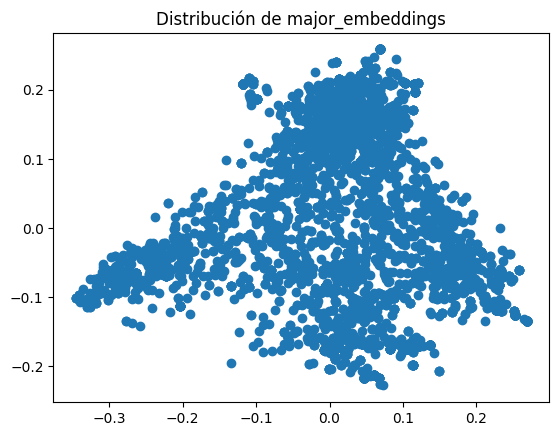

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(list(testing["major_embeddings"]))
plt.scatter(coords[:,0], coords[:,1])
plt.title("Distribución de major_embeddings")
plt.show()

In [ ]:
testing.to_parquet('CleanDB.parquet', index=False)

Guardamos nuestra data con solo el Progresso de la aplicacion que es el target, los años de experiencia y todos los embeddings



---



# Model

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
TrainData = pd.read_parquet('/content/CleanDBFINAL.parquet')

In [ ]:
TrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   candidateId          4500 non-null   object 
 1   jobId                4500 non-null   object 
 2   applicationProgress  4500 non-null   int64  
 3   XpYears              4500 non-null   float64
 4   JobYears             4500 non-null   int64  
 5   job_embeddings       4500 non-null   object 
 6   cert_embeddings      4500 non-null   object 
 7   major_embeddings     4500 non-null   object 
 8   xp_embeddings        4500 non-null   object 
 9   sim_cert_job         4500 non-null   float32
 10  sim_major_job        4500 non-null   float32
 11  sim_xp_job           4500 non-null   float32
dtypes: float32(3), float64(1), int64(2), object(6)
memory usage: 369.3+ KB


In [ ]:
"""TrainData['applicationProgress'] = TrainData['applicationProgress'].replace(2, 1)
#TrainData['applicationProgress'] = TrainData['applicationProgress'].replace(2, 1)"""

In [ ]:
# Count repeated candidateIds
candidate_counts = TrainData['candidateId'].value_counts()
repeated_candidates = candidate_counts[candidate_counts > 1]
print(f"Number of repeated candidateIds: {len(repeated_candidates)}")

# Count repeated jobIds
job_counts = TrainData['jobId'].value_counts()
repeated_jobs = job_counts[job_counts > 1]
print(f"Number of repeated jobIds: {len(repeated_jobs)}")


Number of repeated candidateIds: 550
Number of repeated jobIds: 820


In [ ]:
TrainData['applicationProgress'].value_counts()

,count
applicationProgress,
1,1500
0,1500
2,1500


In [ ]:
TrainData.head()

,candidateId,jobId,applicationProgress,XpYears,JobYears,job_embeddings,cert_embeddings,major_embeddings,xp_embeddings,sim_cert_job,sim_major_job,sim_xp_job
0,2205,23722,1,9.0,2,"[0.017001705, 0.027242724, -0.005167098, 0.059...","[0.027443659, 0.027575485, -0.03506596, 0.0119...","[0.02917811, 0.01771868, 0.0044676415, 0.00203...","[0.02334458, 0.0013495611, -0.007702808, 0.050...",0.807258,0.788681,0.832627
1,30524,27382,0,1.0,2,"[0.024942316, 0.04530538, -0.018107772, 0.0414...","[0.045242336, 0.023878137, -0.027049994, 0.002...","[0.032450315, 0.051903505, -0.012423675, 0.022...","[0.011322078, 0.006506987, -0.009584595, 0.049...",0.787524,0.769299,0.826750
2,335237,63222,1,7.0,1,"[0.002247226, 0.024157178, -0.024665995, 0.034...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0066556986, 0.027665567, 0.0024947512, 0.05...","[-0.005374946, 0.017379424, -0.013259803, 0.02...",0.756202,0.740225,0.813856
3,11226,8002,1,3.0,0,"[0.026881374, 0.045823414, -0.00057912926, 0.0...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[-0.008793229, 0.03318238, -0.0018340672, 0.01...","[0.006143045, 0.0077649397, -0.0074690506, 0.0...",0.779437,0.804967,0.839701
4,6390,43045,2,5.0,0,"[0.03315833, 0.026465718, -0.015022508, -0.000...","[-0.016153395, 0.012192346, -0.01763582, 0.001...","[0.0024537924, 0.03560316, -0.020001188, 0.010...","[0.040212885, 0.018703796, -0.021450544, 0.006...",0.781575,0.805008,0.881311


In [ ]:
def calcular_score_fusionado(row):
    # Penalización si la experiencia del trabajo excede la del candidato
    penalizacion = 0.85 if row["JobYears"] > row["XpYears"] else 1

    # Ponderación: más peso a sim_xp_job
    score = (
        row["sim_xp_job"] * 0.5 +
        row["sim_major_job"] * 0.3 +
        row["sim_cert_job"] * 0.2
    )

    # Penalización aplicada
    return score * penalizacion

TrainData["score_combinado"] = TrainData.apply(calcular_score_fusionado, axis=1)

In [ ]:
embedding_columns = ["job_embeddings", "cert_embeddings", "major_embeddings", "xp_embeddings"]
for col in embedding_columns:

    embedding_array = np.array(TrainData[col].tolist())
    new_cols = [f"{col[:-10]}_emb_{i}" for i in range(embedding_array.shape[1])]  # elimina "_embeddings"
    embedding_df = pd.DataFrame(embedding_array, columns=new_cols)
    TrainData = pd.concat([TrainData.drop(columns=[col]), embedding_df], axis=1)



---



In [ ]:
from sklearn.decomposition import PCA
ReducedAt = 50
embedding_columns = ["job_embeddings", "cert_embeddings", "major_embeddings", "xp_embeddings"]
# Reducimos los cert_embeddings
for col in embedding_columns:
  cert_matrix = np.array(TrainData[col].tolist())
  pca = PCA(n_components=ReducedAt)
  cert_pca = pca.fit_transform(cert_matrix)

  # Agregamos al DataFrame
  for i in range(ReducedAt):
      TrainData[f"{col[:-10]}_emb_{i}"] = cert_pca[:, i]


<ipython-input-751-44e981188855>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TrainData[f"{col[:-10]}_emb_{i}"] = cert_pca[:, i]
<ipython-input-751-44e981188855>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  TrainData[f"{col[:-10]}_emb_{i}"] = cert_pca[:, i]
<ipython-input-751-44e981188855>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-



---



In [ ]:
TrainData.drop(columns=["cert_embeddings","job_embeddings","major_embeddings","xp_embeddings","candidateId","jobId"], inplace=True, errors="ignore")

In [ ]:
TrainData

,applicationProgress,XpYears,JobYears,sim_cert_job,sim_major_job,sim_xp_job,score_combinado,job__emb_0,job__emb_1,job__emb_2,...,xp__emb_758,xp__emb_759,xp__emb_760,xp__emb_761,xp__emb_762,xp__emb_763,xp__emb_764,xp__emb_765,xp__emb_766,xp__emb_767
0,1,9.0,2,0.807258,0.788681,0.832627,0.814369,0.017002,0.027243,-0.005167,...,-0.029407,-0.013747,0.029427,0.025525,0.031474,0.001270,0.083956,-0.040879,-0.023452,0.006450
1,0,1.0,2,0.787524,0.769299,0.826750,0.681419,0.024942,0.045305,-0.018108,...,-0.037758,-0.003043,0.031101,0.015174,0.027978,-0.015117,0.083959,-0.017425,-0.039537,0.025553
2,1,7.0,1,0.756202,0.740225,0.813856,0.780236,0.002247,0.024157,-0.024666,...,-0.021628,-0.009418,0.014194,0.010134,0.038796,-0.022547,0.057717,-0.022440,-0.044877,0.059685
3,1,3.0,0,0.779437,0.804967,0.839701,0.817228,0.026881,0.045823,-0.000579,...,-0.035574,0.017407,0.025256,0.029073,0.035793,-0.038960,0.065090,-0.008469,-0.019360,0.056320
4,2,5.0,0,0.781575,0.805008,0.881311,0.838473,0.033158,0.026466,-0.015023,...,-0.016432,0.014343,0.018256,0.007944,0.034517,-0.009463,0.073016,-0.044260,-0.019581,0.017530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,0,0.0,0,0.769510,0.778098,0.782363,0.778513,0.029132,0.051061,-0.010438,...,-0.032562,0.003065,0.028854,0.007398,0.002890,0.004922,0.082035,-0.017955,-0.058604,0.000275
4496,2,12.0,1,0.788339,0.786654,0.865939,0.826633,0.030570,0.047803,-0.018652,...,-0.055758,0.009954,0.031696,0.001482,0.014815,-0.019720,0.069784,-0.030822,-0.050834,0.030093
4497,0,1.0,0,0.769185,0.836330,0.848300,0.828886,0.024211,0.047873,0.004495,...,-0.012702,0.006633,0.017146,0.013876,0.035394,-0.020948,0.098497,-0.037007,-0.025180,-0.004168
4498,0,2.0,1,0.830014,0.825604,0.832990,0.830179,0.025426,0.037439,0.006930,...,-0.031808,0.012809,0.040476,0.026088,0.010203,-0.019426,0.080441,-0.022657,-0.026774,0.019977


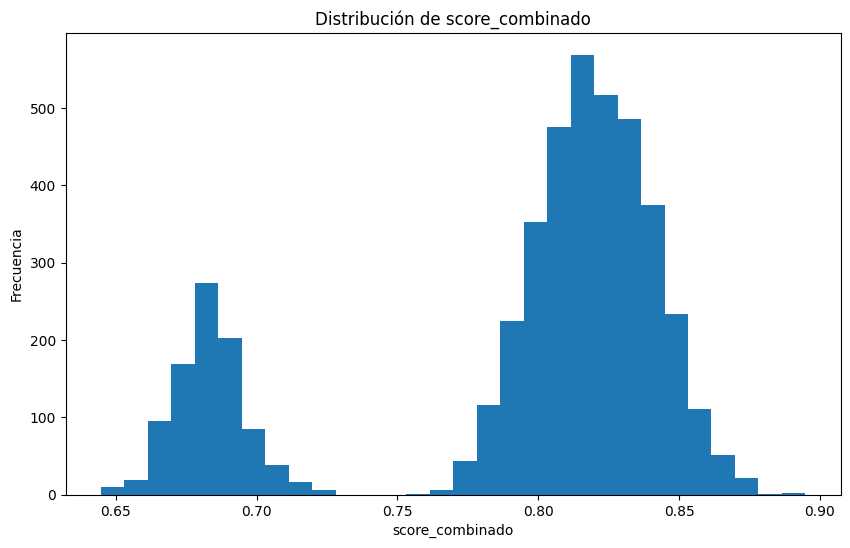

In [ ]:
import matplotlib.pyplot as plt
# Graficar la columna 'score_combinado'
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura
TrainData['score_combinado'].hist(bins=30) # Usamos un histograma para ver la distribución
plt.title('Distribución de score_combinado')
plt.xlabel('score_combinado')
plt.ylabel('Frecuencia')
plt.grid(False) # Oculta la cuadrícula por defecto si no la necesitas
plt.show()

Red neuronal

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = TrainData.drop(columns=["applicationProgress","candidateId","jobId"], errors="ignore")
y = TrainData["applicationProgress"]
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear pipeline con escalado + MLP
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(256, 128),  # Dos capas ocultas
        activation='relu',
        solver='adam',
        alpha=1e-4,  # regularización L2
        learning_rate='adaptive',
        max_iter=1000,
        random_state=69
    ))
])

pipeline.fit(X_train, y_train)
print("Train score:", pipeline.score(X_train, y_train))
print("Test score:", pipeline.score(X_test, y_test))


ValueError: could not convert string to float: 'bueno'



---



In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
import joblib

# Datos
X = TrainData.drop(columns=["applicationProgress","candidateId","jobId","job_embeddings","cert_embeddings","major_embeddings","xp_embeddings"], errors="ignore")
y = TrainData["applicationProgress"]

# Dividir los datos en 80% para entrenamiento y 10% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=81,stratify=y) #stratify with Y to balance


model = XGBClassifier(
    objective="reg:squarederror",
    num_class=3,
    eval_metric="mlogloss",
    enable_categorical = True,
    use_label_encoder=False,

    # Baja profundidad para evitar sobreajuste
    max_depth=3,

    # Aumenta la regularización
    min_child_weight=15,   # más agresivo contra overfitting
    gamma=0.3,            # obliga a que las divisiones sean más significativas
    alpha=0.5 ,            # L1 regularization
    reg_lambda=1.5,       # L2 regularization

    # Control del muestreo
    subsample=0.7,        # más drop de datos aleatoriamente
    colsample_bytree=1, # menos features por árbol

    # Más árboles pequeños en lugar de pocos grandes
    n_estimators=800,
    learning_rate=0.15,
    random_state = 81,
    early_stopping_rounds=10
)
# Entrenar el modelo con todos los datos
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.05934
[1]	validation_0-mlogloss:1.03126
[2]	validation_0-mlogloss:1.00416
[3]	validation_0-mlogloss:0.98491
[4]	validation_0-mlogloss:0.96834
[5]	validation_0-mlogloss:0.95378
[6]	validation_0-mlogloss:0.93995
[7]	validation_0-mlogloss:0.92546
[8]	validation_0-mlogloss:0.91508
[9]	validation_0-mlogloss:0.90424
[10]	validation_0-mlogloss:0.89481
[11]	validation_0-mlogloss:0.88759
[12]	validation_0-mlogloss:0.88115
[13]	validation_0-mlogloss:0.87359
[14]	validation_0-mlogloss:0.86750
[15]	validation_0-mlogloss:0.86210
[16]	validation_0-mlogloss:0.85717
[17]	validation_0-mlogloss:0.85444
[18]	validation_0-mlogloss:0.84770
[19]	validation_0-mlogloss:0.84311
[20]	validation_0-mlogloss:0.84175
[21]	validation_0-mlogloss:0.83839
[22]	validation_0-mlogloss:0.83596
[23]	validation_0-mlogloss:0.83522
[24]	validation_0-mlogloss:0.83173
[25]	validation_0-mlogloss:0.82751
[26]	validation_0-mlogloss:0.82466
[27]	validation_0-mlogloss:0.82293
[28]	validation_0-mlogloss:0.8

XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=10, enable_categorical=True,
              eval_metric='mlogloss', feature_types=None, gamma=0.3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None, num_class=3, ...)



---





---



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 6, 10],
    'gamma': [0, 0.1, 0.3],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [0, 0.5, 1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
print("Best parameters:", grid_search.best_params_)


In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluar el modelo usando validación cruzada
cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")

# Imprimir las puntuaciones
print(f"Precisión promedio de la validación cruzada: {cv_scores.mean()}")
print(f"Desviación estándar: {cv_scores.std()}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:53:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:53:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:54:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/training.py", line 182, in train
    if cb_container.after_iteration(bst, i, dtrain, evals):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/callback.py", line 261, in after_iteration
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/callback.py", line 261, in <genexpr>
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/callback.py", line 446, in after_iteration
    raise ValueError(msg)
ValueError: Must have at least 1 validation dataset for early stopping.




---



In [ ]:
joblib.dump(model, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [ ]:
import joblib
model = joblib.load('/content/xgboost_model.pkl')

In [ ]:
print(y_train[:5])
print(y_train.shape)

696     0
1970    1
4474    1
996     2
2401    2
Name: applicationProgress, dtype: int64
(3600,)


In [ ]:
from sklearn.metrics import mean_absolute_error
print("MAE Test (ordinal error):", mean_absolute_error(y_test, y_test_pred))

MAE Test (ordinal error): 0.5866666666666667


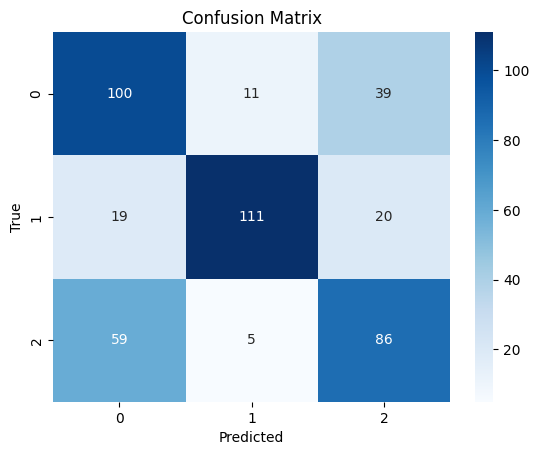

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
cm

array([[100,  11,  39],
       [ 19, 111,  20],
       [ 59,   5,  86]])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Obtener probabilidades
y_train_probs = model.predict_proba(X_train)
y_test_probs = model.predict_proba(X_test)

# Predicciones
y_train_pred = np.argmax(y_train_probs, axis=1)
y_test_pred = np.argmax(y_test_probs, axis=1)

# Aseguramos que y_train/y_test sean arrays simples
y_train = np.array(y_train)
y_test = np.array(y_test)

# Accuracy y classification report
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification report (Train):")
print(classification_report(y_train, y_train_pred))

print("\nClassification report (Test):")
print(classification_report(y_test, y_test_pred))

# ROC AUC para multiclase
try:
    lb = LabelBinarizer()
    lb.fit(y_train)  # entrenamos el binarizador con todas las clases
    y_train_bin = lb.transform(y_train)
    y_test_bin = lb.transform(y_test)

    roc_train = roc_auc_score(y_train_bin, y_train_probs, multi_class='ovr', average='macro')
    roc_test = roc_auc_score(y_test_bin, y_test_probs, multi_class='ovr', average='macro')

    print(f"\nROC AUC (Train): {roc_train:.4f}")
    print(f"ROC AUC (Test): {roc_test:.4f}")
except Exception as e:
    print("\nROC AUC no disponible:", e)


Train Accuracy: 0.9027160493827161
Test Accuracy: 0.9111111111111111

Classification report (Train):
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1350
           1       0.92      0.91      0.92      1350
           2       0.90      0.89      0.90      1350

    accuracy                           0.90      4050
   macro avg       0.90      0.90      0.90      4050
weighted avg       0.90      0.90      0.90      4050


Classification report (Test):
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       150
           1       0.95      0.89      0.92       150
           2       0.91      0.90      0.90       150

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450


ROC AUC (Train): 0.9757
ROC AUC (Test): 0.9795


Test

In [ ]:
# Obtener las probabilidades
probabilities = model.predict_proba(X_test)

# Obtener el porcentaje de la clase más probable (solo el valor más alto de cada fila)
percentages = probabilities.max(axis=1) * 100

# Mostrar el porcentaje
print(percentages)

[68.81225  52.718365 63.623714 59.192856 65.38789  53.52028  75.039604
 80.74261  51.8052   52.0715   66.76721  71.00181  61.80116  58.57284
 88.817276 75.901985 92.12111  91.18977  72.77768  84.9532   65.44391
 75.8613   57.678635 50.03516  65.017685 66.47596  84.29497  60.277496
 77.054184 92.39702  55.130203 76.24581  66.46712  96.31021  67.660995
 93.443344 66.84776  87.55947  61.4634   67.44057  63.972145 54.31369
 79.7077   53.24103  66.48516  91.5466   68.46337  88.87189  79.89656
 80.73202  71.75575  89.66173  67.069534 61.844135 67.0694   67.123405
 62.07238  81.1854   60.258026 66.05882  53.25706  69.07167  76.13586
 55.666115 72.61532  82.53006  67.98238  74.38448  62.766148 86.71559
 69.201836 70.57457  66.784424 59.963955 62.354763 65.53374  54.12978
 52.42991  86.478165 74.59083  73.62585  62.113445 87.70472  55.863388
 83.55354  76.99448  84.30635  96.33158  67.32157  59.246082 63.282078
 67.869514 72.435234 69.39208  65.5063   58.079    84.86196  57.714104
 77.620445 62

In [ ]:
min(percentages) # Porcetanjes simulados (como se veran deployados)

np.float32(31.26249)

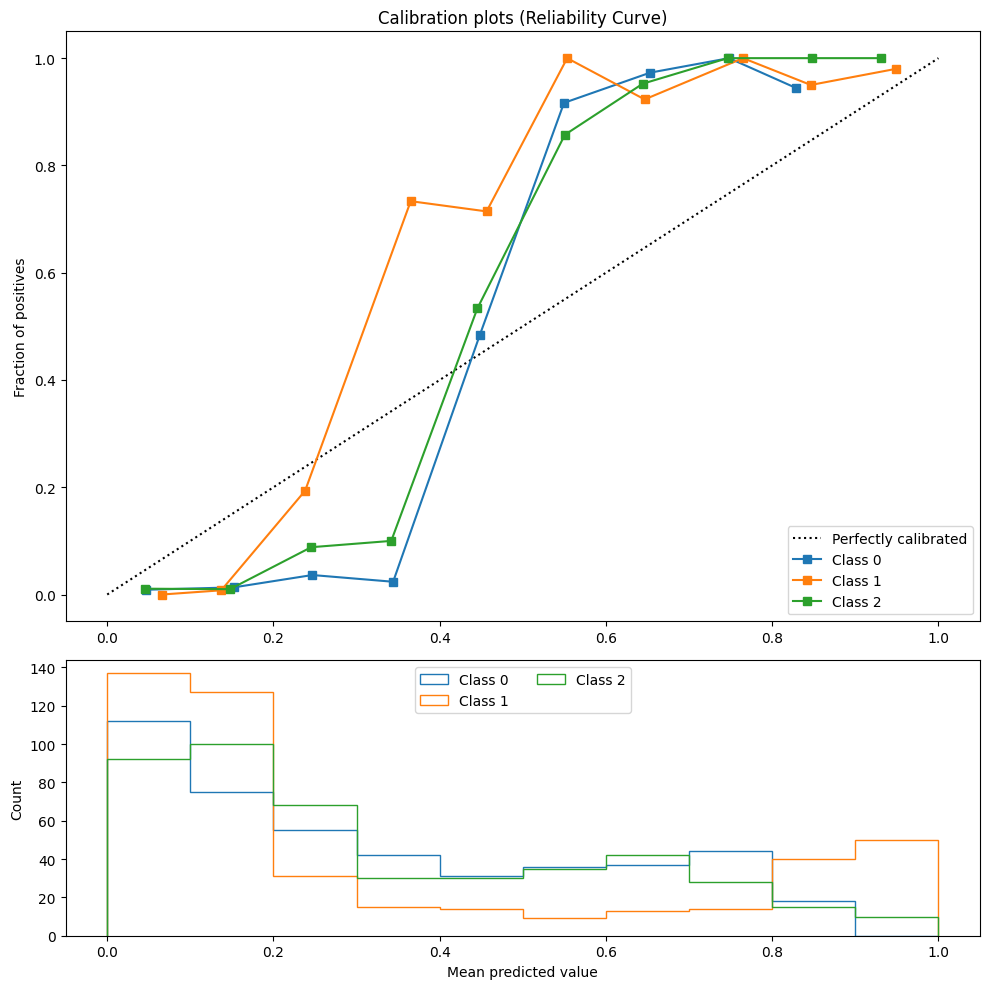

In [ ]:
from sklearn.calibration import calibration_curve

# Obtener las probabilidades predichas para cada clase en el conjunto de prueba
y_prob = model.predict_proba(X_test)

# Como es un problema multiclase, podemos crear un diagrama de fiabilidad para cada clase
# O bien, para la clase positiva si reducimos a binario o nos enfocamos en una clase.
# Aquí, vamos a enfocarnos en un enfoque One-vs-Rest (OvR) para cada clase.

# Define el número de bins para el diagrama
n_bins = 10

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Loop a través de cada clase
for i in range(model.n_classes_): # assuming model has n_classes_ attribute for XGBoost
    # Calculate calibration curve for class i
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test == i, y_prob[:, i], n_bins=n_bins
    )

    ax1.plot(
        mean_predicted_value,
        fraction_of_positives,
        "s-",
        label=f"Class {i}",
    )

    # Plot histogram of predicted probabilities for class i
    ax2.hist(y_prob[:, i], range=(0, 1), bins=n_bins, label=f"Class {i}", histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title("Calibration plots (Reliability Curve)")

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()


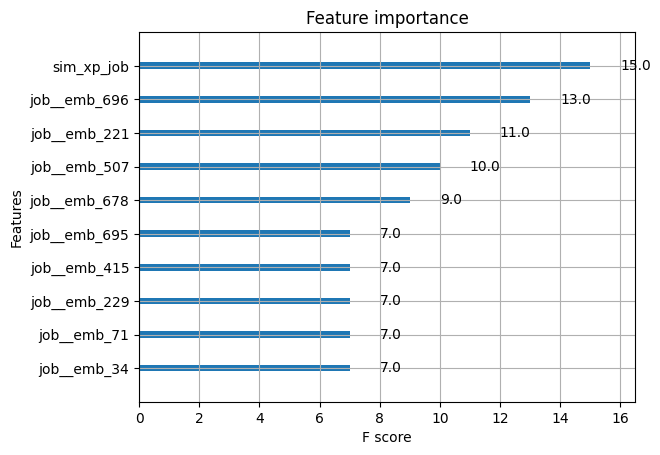

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Graficar la importancia de las características
plot_importance(model, importance_type='weight', max_num_features=10)
plt.show()

In [ ]:
TrainData.head()

,applicationProgress,XpYears,JobYears,sim_cert_job,sim_major_job,sim_xp_job,score_combinado,job__emb_0,job__emb_1,job__emb_2,...,xp__emb_758,xp__emb_759,xp__emb_760,xp__emb_761,xp__emb_762,xp__emb_763,xp__emb_764,xp__emb_765,xp__emb_766,xp__emb_767
0,1,9.0,2,0.807258,0.788681,0.832627,0.814369,0.017002,0.027243,-0.005167,...,-0.029407,-0.013747,0.029427,0.025525,0.031474,0.001270,0.083956,-0.040879,-0.023452,0.006450
1,0,1.0,2,0.787524,0.769299,0.826750,0.681419,0.024942,0.045305,-0.018108,...,-0.037758,-0.003043,0.031101,0.015174,0.027978,-0.015117,0.083959,-0.017425,-0.039537,0.025553
2,1,7.0,1,0.756202,0.740225,0.813856,0.780236,0.002247,0.024157,-0.024666,...,-0.021628,-0.009418,0.014194,0.010134,0.038796,-0.022547,0.057717,-0.022440,-0.044877,0.059685
3,1,3.0,0,0.779437,0.804967,0.839701,0.817228,0.026881,0.045823,-0.000579,...,-0.035574,0.017407,0.025256,0.029073,0.035793,-0.038960,0.065090,-0.008469,-0.019360,0.056320
4,2,5.0,0,0.781575,0.805008,0.881311,0.838473,0.033158,0.026466,-0.015023,...,-0.016432,0.014343,0.018256,0.007944,0.034517,-0.009463,0.073016,-0.044260,-0.019581,0.017530


In [ ]:
TrainData['XpYears'].max()

25.0

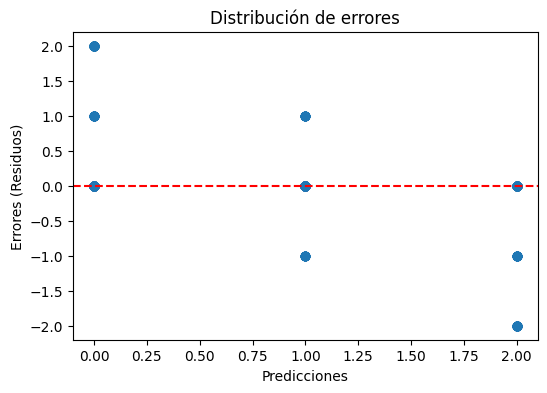

In [ ]:
# Predicciones y residuos
y_pred = model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Distribución de errores')
plt.xlabel('Predicciones')
plt.ylabel('Errores (Residuos)')
plt.show()

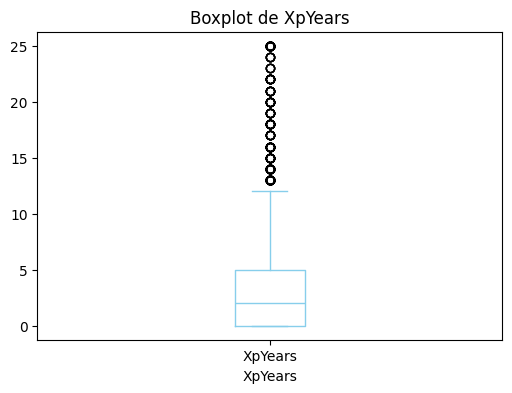

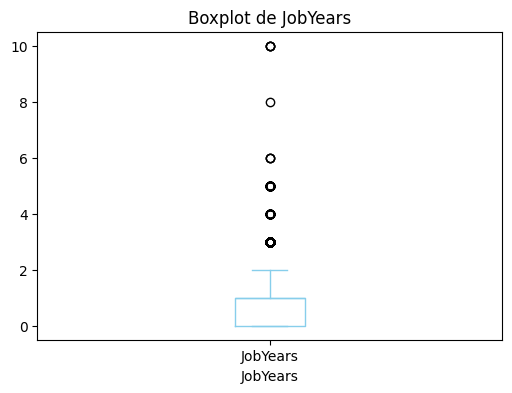

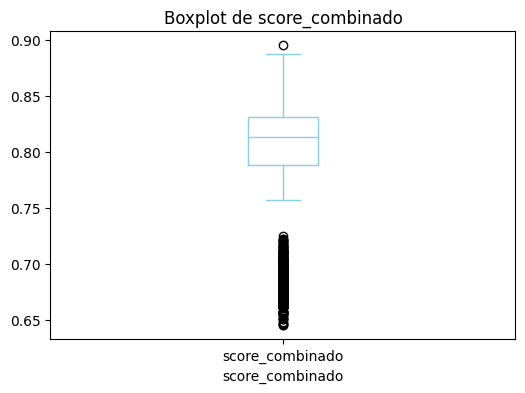

In [ ]:
for column in X.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6, 4))
    X[column].plot(kind='box', color='skyblue')
    plt.title(f"Boxplot de {column}")
    plt.xlabel(column)
    plt.show()

## API

In [ ]:
#DATA
Years = 5
Major = "Enfermería en anestesia, Paramédico, Supervisor"
Certifications = "Título profesional, Cédula profesional,Servicio integral de anestesia,Manejo de indicadores,Excel intermedio, Regulación Sanitaria"
Experience = "Supervisor de enfermería, Enfermeroa, Paramédico, Servicio integral de anestesia, Manejo de indicadores"

In [ ]:
Job = """
Principales responsabilidades del puesto:
Supervisar el proceso del servicio de anestesiología en los quirófanos de forma diaria y los diferentes turnos asegurando el cumplimiento de los indicadores y analizar desviaciones que de puedan generar (desde inventarios, personal, revisión de sábanos, cierres y validaciones).
Elaborar y analizar indicadores diarios y semanales con la finalidad de dar seguimiento a los siguientes procesos: revisión con el responsable de anestesiología del hospital, para el proceso de cobranza, asegurar el inventario y como retroalimentación para el personal a cargo.
Gestión de personal, identificando necesidades con los Asistentes de quirófano y Auxiliares de Farmacia con enfoque a mejorar la operación
Nivel educativo:
Escolaridad concluida con documento obligatorio (Titulo y Cedula)

Enfermería o Paramédico.

Experiencia:
Experiencia como Supervisor (1 año - obligatorio)
Experiencia en enfermería o paramédico (2 año -  obligatorio)
Servicio integral de anestesia (1 año - deseable)
Manejo de indicadores. (1 año - deseable)

Conocimientos mandatorios:
Medicamentos y material de curación (Obligatorio)
Manejo de la vía aérea (Obligatorio)
Excel intermedio (Obligatorio)
Regulación Sanitaria (Deseable)

Otros requisitos:
Disponibilidad de rolar turnos.
Disponibilidad para viajar alrededor de 1 vez al año.

Tipo de contrato:
Temporal
Los procesos de reclutamiento, evaluación, entrevista, selección y contratación de personal, son totalmente GRATUITOS en Grupo PiSA; nadie debe solicitarte pago alguno para participar en nuestros procesos de Reclutamiento y Selección.

Por favor reporta cualquier solicitud extraña en el proceso para ingresar a Grupo PiSA.

linearh@pisa.com.mx

Paso 1: Ingresa a la página: selectia.pisa.com.mx
Paso 2: Mencionar su Número de empleado al darse de alta.
Paso 3: Da clic en la pestaña “Bolsa de Talento Selectia”
Paso 4: Selecciona la opción “Vacantes”
Paso 5: Da clic ”Como aplicar  a una vacante en Selectia”
"""


In [ ]:
def get_embedding(text, model):
    return model.encode(text)

def embedding_to_columns(vector, prefix):
    return pd.DataFrame([vector], columns=[f"{prefix}_{i}" for i in range(len(vector))])

In [ ]:
import re
regex_job_years = re.compile(
    r"(?:(\d+)\s*(año|años|year|years))|(?:(año|años|year|years)\s*(\d+))",
    re.IGNORECASE
)
def extract_job_years(text):
    if pd.isna(text):
        return 0

    matches = regex_job_years.findall(text)

    # Recolectar todos los números encontrados
    years = []
    for match in matches:
        if match[0]:
            years.append(int(match[0]))
        elif match[3]:
            years.append(int(match[3]))

    if not years:
        return 0

    # Si el primer valor es mayor a 10, buscar otro que no lo sea
    if years[0] > 10:
        for y in years[1:]:
            if y <= 10:
                return y
        return 0  # No se encontró ninguno menor o igual a 10
    else:
        return years[0]

In [ ]:
def calcular_score_fusionado(row):
    # Penalización si la experiencia del trabajo excede la del candidato
    penalizacion = 0.85 if row["JobYears"] > row["XpYears"] else 1

    # Ponderación: más peso a sim_xp_job
    score = (
        row["sim_xp_job"] * 0.5 +
        row["sim_major_job"] * 0.3 +
        row["sim_cert_job"] * 0.2
    )

    # Penalización aplicada
    return score * penalizacion

In [ ]:
import re
import unicodedata

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Reemplaza tildes, pero conserva la ñ
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i',
        'ó': 'o', 'ú': 'u', 'Á': 'a', 'É': 'e',
        'Í': 'i', 'Ó': 'o', 'Ú': 'u'
    }
    for original, replacement in replacements.items():
        text = text.replace(original, replacement)

    # Mantener caracteres válidos y la ñ
    text = re.sub(r'[^\w\s,.:-ñÑ]', '', text)
    text = re.sub(r'\s+', ' ', text)

    return text.strip().lower()


def clean_job_description(raw_text):
    raw_text=clean_text(raw_text)

    lines = raw_text.split('\n') if '\n' in raw_text else raw_text.split('.')
    lines = [l.strip() for l in lines if l.strip() != ""]

    #quedarse con líneas que tengan ciertas palabras clave
    key_lines = [l for l in lines if (
        any(kw in l.lower() for kw in [
            'responsab', 'requisito', 'experienc', 'conocimiento','educaci','rol','labor'
            'nivel educativo', 'puesto', 'habilidad', 'actividades', 'funciones', 'años', 'mínimo'
        ])
        or re.search(r'\d+\s*(años|year)', l.lower())
    )]

    if not key_lines:
        key_lines = lines[-5:]  # si no encontró nada, tomar final

    # Combinar de nuevo en texto final
    return '. '.join(key_lines)

In [ ]:
Job = clean_job_description(Job)

In [ ]:
Job

'principales responsabilidades del puesto: supervisar el proceso del servicio de anestesiologia en los quirofanos de forma diaria y los diferentes turnos asegurando el cumplimiento de los indicadores y analizar desviaciones que de puedan generar desde inventarios, personal, revision de sabanos, cierres y validaciones. elaborar y analizar indicadores diarios y semanales con la finalidad de dar seguimiento a los siguientes procesos: revision con el responsable de anestesiologia del hospital, para el proceso de cobranza, asegurar el inventario y como retroalimentacion para el personal a cargo. experiencia: experiencia como supervisor 1 año obligatorio experiencia en enfermeria o paramedico 2 año obligatorio servicio integral de anestesia 1 año deseable manejo de indicadores. 1 año deseable conocimientos mandatorios: medicamentos y material de curacion obligatorio manejo de la via aerea obligatorio excel intermedio obligatorio regulacion sanitaria deseable otros requisitos: disponibilidad 

In [ ]:
JobYears = extract_job_years(Job)

In [ ]:
JobYears

1

In [ ]:
from sentence_transformers import SentenceTransformer
#modelenc = SentenceTransformer('distiluse-base-multilingual-cased-v2')
modelenc = SentenceTransformer('intfloat/multilingual-e5-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/179k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [ ]:
if Experience != 'Sin experiencia laboral relevante':
   Experience = str(Years) + ' años de experiencia trabajando de ' + Experience

In [ ]:
Experience

'5 años de experiencia trabajando de Supervisor de enfermería, Enfermeroa, Paramédico, Servicio integral de anestesia, Manejo de indicadores'

In [ ]:
# Obtén embeddings
vec_edu = get_embedding(Major, modelenc)
vec_exp = get_embedding(Experience, modelenc)
vec_certs = get_embedding(Certifications, modelenc)
vec_job = get_embedding(Job, modelenc)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Función para similitud coseno
def cosine_sim(a, b):
    return cosine_similarity([a], [b])[0][0]

# Obtener las similitudes
sim_cert_job = cosine_sim(vec_certs, vec_job)
sim_major_job = cosine_sim(vec_edu, vec_job)
sim_xp_job = cosine_sim(vec_exp, vec_job)

df_sim = pd.DataFrame([{
    'XpYears' : Years,
    'JobYears' : JobYears,
    "sim_cert_job": sim_cert_job,
    "sim_major_job": sim_major_job,
    "sim_xp_job": sim_xp_job,
}])
df_sim['score_combinado'] = calcular_score_fusionado(df_sim.iloc[0])

In [ ]:
df_sim

,XpYears,JobYears,sim_cert_job,sim_major_job,sim_xp_job,score_combinado
0,5,1,0.852451,0.858626,0.886395,0.871275


In [ ]:
# Convertir embeddings a columnas
df_edu = embedding_to_columns(vec_edu, "major__emb")
df_exp = embedding_to_columns(vec_exp, "xp__emb")
df_certs = embedding_to_columns(vec_certs, "cert__emb")
df_job = embedding_to_columns(vec_job, "job__emb")

# Concatenar todo
df_sim = pd.concat([df_sim, df_job, df_certs, df_edu, df_exp], axis=1)

# Mostrar resultado
df_sim


,XpYears,JobYears,sim_cert_job,sim_major_job,sim_xp_job,score_combinado,job__emb_0,job__emb_1,job__emb_2,job__emb_3,...,xp__emb_758,xp__emb_759,xp__emb_760,xp__emb_761,xp__emb_762,xp__emb_763,xp__emb_764,xp__emb_765,xp__emb_766,xp__emb_767
0,5,1,0.852451,0.858626,0.886395,0.871275,0.030038,0.032737,0.002717,0.043716,...,-0.025354,0.020404,0.033168,0.027848,0.032792,-0.01247,0.069422,-0.045644,-0.047433,-0.021459


In [ ]:
"""# Define the mapping dictionary
xp_years_mapping = {
    range(0, 2): 0,
    range(2, 5): 1,
    range(5, 7): 2,
    range(7, 11): 3,
    range(11, 1000): 4  # Handle values greater than 10
}

# Function to apply the mapping
def map_xp_years(xp_years):
    for xp_range, mapped_value in xp_years_mapping.items():
        if xp_years in xp_range:
            return mapped_value
    return xp_years  # Return original value if no mapping found

# Apply the mapping to the 'XpYears' column
df_final['XpYears'] = df_final['XpYears'].apply(map_xp_years)"""

In [ ]:
print(X_train.columns.tolist())

['XpYears', 'JobYears', 'sim_cert_job', 'sim_major_job', 'sim_xp_job', 'score_combinado', 'job__emb_0', 'job__emb_1', 'job__emb_2', 'job__emb_3', 'job__emb_4', 'job__emb_5', 'job__emb_6', 'job__emb_7', 'job__emb_8', 'job__emb_9', 'job__emb_10', 'job__emb_11', 'job__emb_12', 'job__emb_13', 'job__emb_14', 'job__emb_15', 'job__emb_16', 'job__emb_17', 'job__emb_18', 'job__emb_19', 'job__emb_20', 'job__emb_21', 'job__emb_22', 'job__emb_23', 'job__emb_24', 'job__emb_25', 'job__emb_26', 'job__emb_27', 'job__emb_28', 'job__emb_29', 'job__emb_30', 'job__emb_31', 'job__emb_32', 'job__emb_33', 'job__emb_34', 'job__emb_35', 'job__emb_36', 'job__emb_37', 'job__emb_38', 'job__emb_39', 'job__emb_40', 'job__emb_41', 'job__emb_42', 'job__emb_43', 'job__emb_44', 'job__emb_45', 'job__emb_46', 'job__emb_47', 'job__emb_48', 'job__emb_49', 'job__emb_50', 'job__emb_51', 'job__emb_52', 'job__emb_53', 'job__emb_54', 'job__emb_55', 'job__emb_56', 'job__emb_57', 'job__emb_58', 'job__emb_59', 'job__emb_60', 'job_

In [ ]:
print(df_sim.columns.tolist())

['XpYears', 'JobYears', 'sim_cert_job', 'sim_major_job', 'sim_xp_job', 'score_combinado', 'job__emb_0', 'job__emb_1', 'job__emb_2', 'job__emb_3', 'job__emb_4', 'job__emb_5', 'job__emb_6', 'job__emb_7', 'job__emb_8', 'job__emb_9', 'job__emb_10', 'job__emb_11', 'job__emb_12', 'job__emb_13', 'job__emb_14', 'job__emb_15', 'job__emb_16', 'job__emb_17', 'job__emb_18', 'job__emb_19', 'job__emb_20', 'job__emb_21', 'job__emb_22', 'job__emb_23', 'job__emb_24', 'job__emb_25', 'job__emb_26', 'job__emb_27', 'job__emb_28', 'job__emb_29', 'job__emb_30', 'job__emb_31', 'job__emb_32', 'job__emb_33', 'job__emb_34', 'job__emb_35', 'job__emb_36', 'job__emb_37', 'job__emb_38', 'job__emb_39', 'job__emb_40', 'job__emb_41', 'job__emb_42', 'job__emb_43', 'job__emb_44', 'job__emb_45', 'job__emb_46', 'job__emb_47', 'job__emb_48', 'job__emb_49', 'job__emb_50', 'job__emb_51', 'job__emb_52', 'job__emb_53', 'job__emb_54', 'job__emb_55', 'job__emb_56', 'job__emb_57', 'job__emb_58', 'job__emb_59', 'job__emb_60', 'job_

In [ ]:
# Listas de columnas
cols_train = X_train.columns.tolist()
cols_sim = df_sim.columns.tolist()

# Columnas que están en X_train pero NO en df_sim (faltantes)
cols_missing = [c for c in cols_train if c not in cols_sim]

# Columnas que están en df_sim pero NO en X_train (extras)
cols_extra = [c for c in cols_sim if c not in cols_train]

print(f"Columnas en entrenamiento pero faltantes en df_sim ({len(cols_missing)}):")
print(cols_missing)

print(f"\nColumnas en df_sim pero no en entrenamiento ({len(cols_extra)}):")
print(cols_extra)

# Opcional: comparar orden (si tienen las mismas columnas)
if set(cols_train) == set(cols_sim):
    if cols_train == cols_sim:
        print("\nLas columnas están en el mismo orden.")
    else:
        print("\nLas columnas tienen el mismo contenido pero diferente orden.")
else:
    print("\nLas columnas tienen diferencias en contenido, no solo en orden.")


Columnas en entrenamiento pero faltantes en df_sim (0):
[]

Columnas en df_sim pero no en entrenamiento (0):
[]

Las columnas están en el mismo orden.


In [ ]:
probs = model.predict_proba(df_sim)
pred = model.predict(df_sim)
print("Predicción:", pred[0])
print("Probabilidades:", probs[0])  # Ej: [0.01, 0.10, 0.60, 0.29]

Predicción: 2
Probabilidades: [0.2240492  0.15497182 0.62097895]


In [ ]:
labels = {
    0: 34,
    1: 67,
    2: 100
}

def getFinalResult(pred_vector, prob_vector):
    pred_class = pred_vector[0]
    pred_prob = prob_vector[0][pred_class]

    if pred_class == 0:
        return labels[0] * pred_prob  # no hay clase anterior, escala normal

    # Clase previa y actual
    base_current = labels[pred_class]
    base_prev = labels[pred_class - 1]

    # Interpolación: cuanto más baja la probabilidad, más cerca del valor anterior
    resultado = base_prev + (base_current - base_prev) * pred_prob

    print(f"Clase: {pred_class}, Prob: {pred_prob:.3f}, Resultado: {resultado:.2f}")
    return resultado


# Ejemplo:
prediccionF = getFinalResult(pred, probs)
print("El candidato es: ", round(prediccionF), "%")


Clase: 2, Prob: 0.621, Resultado: 87.49
El candidato es:  87 %
